# **Feature Engineering Notebook**

## Objectives

* Perform feature engineering tasks, building on the engineering done as part of data cleaning

## Inputs

* Using /workspace/milestone-project-housing-issues/outputs/datasets/cleaned/HousePricesClean.csv

## Outputs

* Write here which files, code or artefacts you generate by the end of the notebook 

## Additional Comments

* As part of the data cleaning process missing data, data with excessive zero-values, and categorical data have all been transformed
* New binary variables have been created to account for data with excessive zeroes
* Correlation and predictive power scores have been calculated, and the feature engineering notebook will build on the results of these


---

# Change working directory

* We are assuming you will store the notebooks in a subfolder, therefore when running the notebook in the editor, you will need to change the working directory

We need to change the working directory from its current folder to its parent folder
* We access the current directory with os.getcwd()

In [37]:
import os

# Get the current directory
current_dir = os.getcwd()
print("Current Directory:", current_dir)

# Change the directory to the new path
os.chdir('/workspace/milestone-project-housing-issues')

# Get the updated current directory
current_dir = os.getcwd()
print("New Current Directory:", current_dir)

Current Directory: /workspace/milestone-project-housing-issues
New Current Directory: /workspace/milestone-project-housing-issues


In [38]:
# Loading dataset HousePricesClean from /workspace/milestone-project-housing-issues/outputs/datasets/cleaned/HousePricesClean.csv

import pandas as pd
df_houseprices_FE = pd.read_csv(f"/workspace/milestone-project-housing-issues/outputs/datasets/cleaned/HousePricesClean.csv")
df_houseprices_FE.head()

1stFlrSF  BedroomAbvGr  BsmtExposure  BsmtFinType1  GarageFinish  \
0       856             3             1             6             2   
1      1262             3             4             5             2   
2       920             3             2             6             2   
3       961             5             1             5             1   
4      1145             4             3             6             2   

   GarageYrBlt  GrLivArea  KitchenQual  LotArea  LotFrontage  ...  \
0         2003       1710            3     8450           65  ...   
1         1976       1262            2     9600           80  ...   
2         2001       1786            3    11250           68  ...   
3         1998       1717            3     9550           60  ...   
4         2000       2198            3    14260           84  ...   

   TotalBsmtSF  YearBuilt  SalePrice  Has2ndFloor  HasMasVnr  HasOpenPorch  \
0          856       2003     208500            1          1             1   
1         1262       1976     181500            0          0             0   
2          920       2001     223500            1          1             1   
3          756       1915     140000            0          0             1   
4         1145       2000     250000            0          1             1   

   HasGarage  HasFinBsmt  ModsMade  SalePriceBand  
0          1           1         0              4  
1          1           1         0              4  
2          1           1         1              5  
3          1           1         1              2  
4          1           1         0              5  

[5 rows x 22 columns]

In [39]:
df_houseprices_FE.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 22 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   1stFlrSF       1460 non-null   int64
 1   BedroomAbvGr   1460 non-null   int64
 2   BsmtExposure   1460 non-null   int64
 3   BsmtFinType1   1460 non-null   int64
 4   GarageFinish   1460 non-null   int64
 5   GarageYrBlt    1460 non-null   int64
 6   GrLivArea      1460 non-null   int64
 7   KitchenQual    1460 non-null   int64
 8   LotArea        1460 non-null   int64
 9   LotFrontage    1460 non-null   int64
 10  OverallCond    1460 non-null   int64
 11  OverallQual    1460 non-null   int64
 12  TotalBsmtSF    1460 non-null   int64
 13  YearBuilt      1460 non-null   int64
 14  SalePrice      1460 non-null   int64
 15  Has2ndFloor    1460 non-null   int64
 16  HasMasVnr      1460 non-null   int64
 17  HasOpenPorch   1460 non-null   int64
 18  HasGarage      1460 non-null   int64
 19  HasFin

In [23]:
# Revisiting data for feature engineering purposes
from ydata_profiling import ProfileReport

pandas_report = ProfileReport(df_houseprices_FE, minimal=True)
pandas_report.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

# Splitting data into Test and Train datasets

In [40]:
from sklearn.model_selection import train_test_split
TrainSet, TestSet, _, __ = train_test_split(
                    df_houseprices_FE,
                    df_houseprices_FE['SalePriceBand'],
                    test_size=0.2,
                    random_state=0)

print(f"TrainSet shape: {TrainSet.shape} \nTestSet shape: {TestSet.shape}")



TrainSet shape: (1168, 22) 
TestSet shape: (292, 22)


In [41]:
# Saving train and test datasets

## Train Set
TrainSet.to_csv("outputs/datasets/cleaned/TrainSet.csv", index=False)
## Test Set
TestSet.to_csv("outputs/datasets/cleaned/TestSet.csv", index=False)


### Feature Engineering using transformers

In [42]:
# Custom engineering function

import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import warnings
from feature_engine import transformation as vt
from feature_engine.outliers import Winsorizer
from feature_engine.encoding import OrdinalEncoder
sns.set(style="whitegrid")
warnings.filterwarnings('ignore')


df = TrainSet

def FeatureEngineeringAnalysis(df, analysis_type=None):
  """
  - used for quick feature engineering on numerical and categorical variables
  to decide which transformation can better transform the distribution shape
  - Once transformed, use a reporting tool, like ydata-profiling, to evaluate distributions
  """
  check_missing_values(df)
  allowed_types = ['numerical', 'ordinal_encoder', 'outlier_winsorizer']
  check_user_entry_on_analysis_type(analysis_type, allowed_types)
  list_column_transformers = define_list_column_transformers(analysis_type)

  # Loop in each variable and engineer the data according to the analysis type
  df_feat_eng = pd.DataFrame([])
  for column in df.columns:
    # create additional columns (column_method) to apply the methods
    df_feat_eng = pd.concat([df_feat_eng, df[column]], axis=1)
    for method in list_column_transformers:
      df_feat_eng[f"{column}_{method}"] = df[column]

    # Apply transformers in respective column_transformers
    df_feat_eng, list_applied_transformers = apply_transformers(
      analysis_type, df_feat_eng, column)

    # For each variable, assess how the transformations perform
    transformer_evaluation(
      column, list_applied_transformers, analysis_type, df_feat_eng)

  return df_feat_eng


def check_user_entry_on_analysis_type(analysis_type, allowed_types):
  """ Check analysis type """
  if analysis_type is None:
    raise SystemExit(
      f"You should pass analysis_type parameter as one of the following options: {allowed_types}")
  if analysis_type not in allowed_types:
    raise SystemExit(
      f"analysis_type argument should be one of these options: {allowed_types}")


def check_missing_values(df):
  if df.isna().sum().sum() != 0:
    raise SystemExit(
      f"There is a missing value in your dataset. Please handle that before getting into feature engineering.")


def define_list_column_transformers(analysis_type):
  """ Set suffix columns according to analysis_type"""
  if analysis_type == 'numerical':
    list_column_transformers = [
      "log_e", "log_10", "reciprocal", "power", "box_cox", "yeo_johnson"]

  elif analysis_type == 'ordinal_encoder':
    list_column_transformers = ["ordinal_encoder"]

  elif analysis_type == 'outlier_winsorizer':
    list_column_transformers = ['iqr']

  return list_column_transformers


def apply_transformers(analysis_type, df_feat_eng, column):
  for col in df_feat_eng.select_dtypes(include='category').columns:
    df_feat_eng[col] = df_feat_eng[col].astype('object')

  if analysis_type == 'numerical':
    df_feat_eng, list_applied_transformers = FeatEngineering_Numerical(
      df_feat_eng, column)

  elif analysis_type == 'outlier_winsorizer':
    df_feat_eng, list_applied_transformers = FeatEngineering_OutlierWinsorizer(
      df_feat_eng, column)

  elif analysis_type == 'ordinal_encoder':
    df_feat_eng, list_applied_transformers = FeatEngineering_CategoricalEncoder(
      df_feat_eng, column)

  return df_feat_eng, list_applied_transformers


def transformer_evaluation(column, list_applied_transformers, analysis_type, df_feat_eng):
  # For each variable, assess how the transformations perform
  print(f"* Variable Analyzed: {column}")
  print(f"* Applied transformation: {list_applied_transformers} \n")
  for col in [column] + list_applied_transformers:

    if analysis_type != 'ordinal_encoder':
      DiagnosticPlots_Numerical(df_feat_eng, col)

    else:
      if col == column:
        DiagnosticPlots_Categories(df_feat_eng, col)
      else:
        DiagnosticPlots_Numerical(df_feat_eng, col)

    print("\n")


def DiagnosticPlots_Categories(df_feat_eng, col):
  plt.figure(figsize=(4, 3))
  sns.countplot(data=df_feat_eng, x=col, palette=[
         '#432371'])
  plt.xticks(rotation=90)
  plt.suptitle(f"{col}", fontsize=30, y=1.05)
  plt.show()
  print("\n")


def DiagnosticPlots_Numerical(df, variable):
  fig, axes = plt.subplots(1, 3, figsize=(12, 4))
  sns.histplot(data=df, x=variable, kde=True, element="step", ax=axes[0])
  stats.probplot(df[variable], dist="norm", plot=axes[1])
  sns.boxplot(x=df[variable], ax=axes[2])

  axes[0].set_title('Histogram')
  axes[1].set_title('QQ Plot')
  axes[2].set_title('Boxplot')
  fig.suptitle(f"{variable}", fontsize=30, y=1.05)
  plt.tight_layout()
  plt.show()


def FeatEngineering_CategoricalEncoder(df_feat_eng, column):
  list_methods_worked = []
  try:
    encoder = OrdinalEncoder(encoding_method='arbitrary', variables=[
                 f"{column}_ordinal_encoder"])
    df_feat_eng = encoder.fit_transform(df_feat_eng)
    list_methods_worked.append(f"{column}_ordinal_encoder")

  except Exception:
    df_feat_eng.drop([f"{column}_ordinal_encoder"], axis=1, inplace=True)

  return df_feat_eng, list_methods_worked


def FeatEngineering_OutlierWinsorizer(df_feat_eng, columns):
    """
    Applies Winsorization to multiple columns using the IQR method.

    Parameters:
    - df_feat_eng (pd.DataFrame): DataFrame containing the features.
    - columns (list): List of column names to Winsorize.

    Returns:
    - pd.DataFrame: DataFrame with Winsorized columns.
    - list: List of methods that worked.
    """
    list_methods_worked = []

    for column in columns:
        try:
            # Initialize Winsorizer for the current column
            disc = Winsorizer(
                capping_method='iqr',
                tail='both',
                fold=1.5,
                variables=[column]
            )
            # Apply Winsorization
            df_feat_eng = disc.fit_transform(df_feat_eng)
            list_methods_worked.append(f"{column}_iqr")
        except Exception as e:
            # Print error message but continue with other columns
            print(f"Failed to Winsorize {column}: {e}")
    
    # Ensure both the DataFrame and list of applied methods are returned
    return df_feat_eng, list_methods_worked


def FeatEngineering_Numerical(df_feat_eng, column):
  list_methods_worked = []

  # LogTransformer base e
  try:
    lt = vt.LogTransformer(variables=[f"{column}_log_e"])
    df_feat_eng = lt.fit_transform(df_feat_eng)
    list_methods_worked.append(f"{column}_log_e")
  except Exception:
    df_feat_eng.drop([f"{column}_log_e"], axis=1, inplace=True)

  # LogTransformer base 10
  try:
    lt = vt.LogTransformer(variables=[f"{column}_log_10"], base='10')
    df_feat_eng = lt.fit_transform(df_feat_eng)
    list_methods_worked.append(f"{column}_log_10")
  except Exception:
    df_feat_eng.drop([f"{column}_log_10"], axis=1, inplace=True)

  # ReciprocalTransformer
  try:
    rt = vt.ReciprocalTransformer(variables=[f"{column}_reciprocal"])
    df_feat_eng = rt.fit_transform(df_feat_eng)
    list_methods_worked.append(f"{column}_reciprocal")
  except Exception:
    df_feat_eng.drop([f"{column}_reciprocal"], axis=1, inplace=True)

  # PowerTransformer
  try:
    pt = vt.PowerTransformer(variables=[f"{column}_power"])
    df_feat_eng = pt.fit_transform(df_feat_eng)
    list_methods_worked.append(f"{column}_power")
  except Exception:
    df_feat_eng.drop([f"{column}_power"], axis=1, inplace=True)

  # BoxCoxTransformer
  try:
    bct = vt.BoxCoxTransformer(variables=[f"{column}_box_cox"])
    df_feat_eng = bct.fit_transform(df_feat_eng)
    list_methods_worked.append(f"{column}_box_cox")
  except Exception:
    df_feat_eng.drop([f"{column}_box_cox"], axis=1, inplace=True)

  # YeoJohnsonTransformer
  try:
    yjt = vt.YeoJohnsonTransformer(variables=[f"{column}_yeo_johnson"])
    df_feat_eng = yjt.fit_transform(df_feat_eng)
    list_methods_worked.append(f"{column}_yeo_johnson")
  except Exception:
    df_feat_eng.drop([f"{column}_yeo_johnson"], axis=1, inplace=True)

  return df_feat_eng, list_methods_worked


In [43]:
# Converting categorical variables in back into object form for feature engineering

df[['BsmtExposure', 'BsmtFinType1', 'GarageFinish',
            'KitchenQual', 'OverallCond', 'OverallQual',
            'Has2ndFloor', 'HasMasVnr', 'HasOpenPorch', 
            'HasGarage', 'HasFinBsmt', 'ModsMade']] = df[['BsmtExposure', 'BsmtFinType1', 'GarageFinish',
            'KitchenQual', 'OverallCond', 'OverallQual',
            'Has2ndFloor', 'HasMasVnr', 'HasOpenPorch', 
            'HasGarage', 'HasFinBsmt', 'ModsMade']].astype(object)

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1168 entries, 618 to 684
Data columns (total 22 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   1stFlrSF       1168 non-null   int64 
 1   BedroomAbvGr   1168 non-null   int64 
 2   BsmtExposure   1168 non-null   object
 3   BsmtFinType1   1168 non-null   object
 4   GarageFinish   1168 non-null   object
 5   GarageYrBlt    1168 non-null   int64 
 6   GrLivArea      1168 non-null   int64 
 7   KitchenQual    1168 non-null   object
 8   LotArea        1168 non-null   int64 
 9   LotFrontage    1168 non-null   int64 
 10  OverallCond    1168 non-null   object
 11  OverallQual    1168 non-null   object
 12  TotalBsmtSF    1168 non-null   int64 
 13  YearBuilt      1168 non-null   int64 
 14  SalePrice      1168 non-null   int64 
 15  Has2ndFloor    1168 non-null   object
 16  HasMasVnr      1168 non-null   object
 17  HasOpenPorch   1168 non-null   object
 18  HasGarage      1168 non-nul

* Variable Analyzed: BsmtExposure
* Applied transformation: ['BsmtExposure_ordinal_encoder'] 



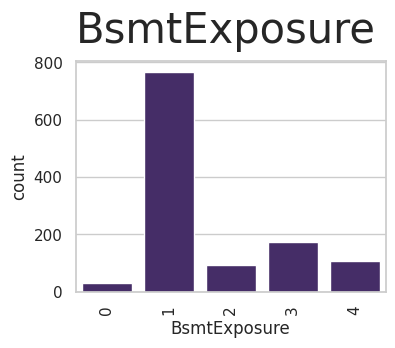

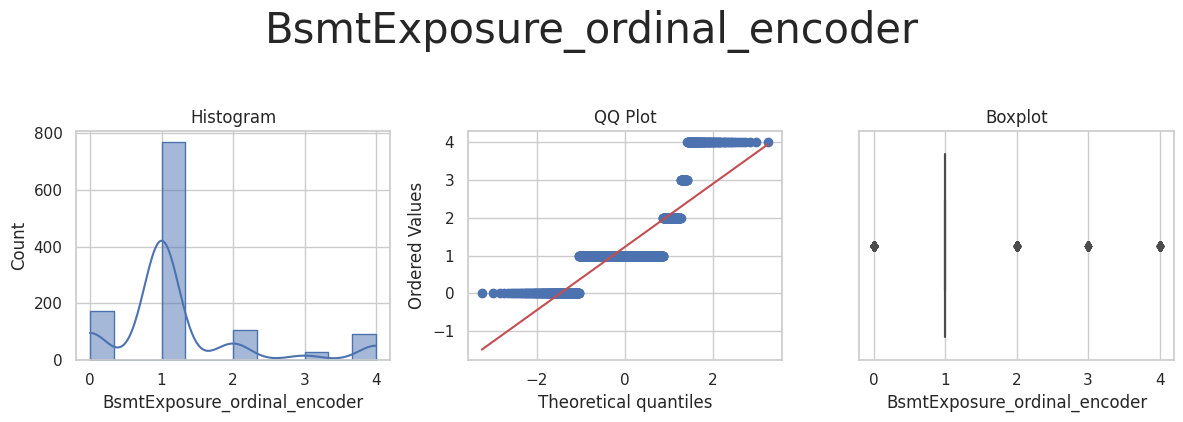



* Variable Analyzed: BsmtFinType1
* Applied transformation: ['BsmtFinType1_ordinal_encoder'] 



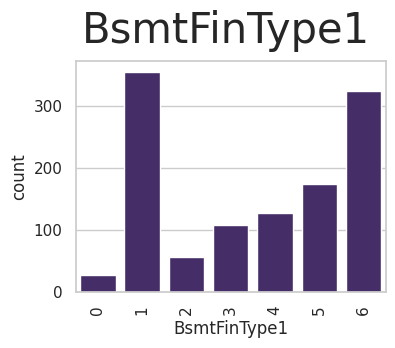

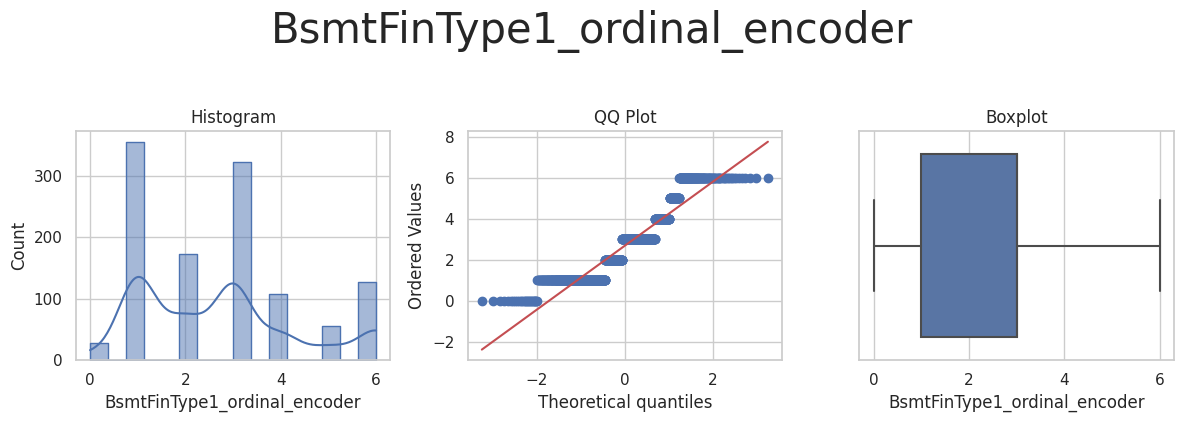



* Variable Analyzed: GarageFinish
* Applied transformation: ['GarageFinish_ordinal_encoder'] 



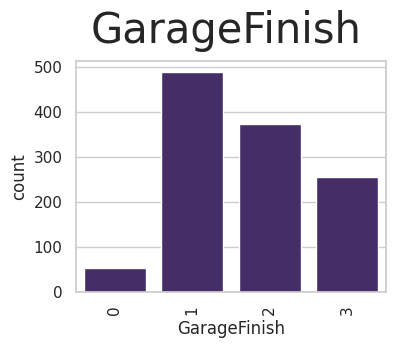

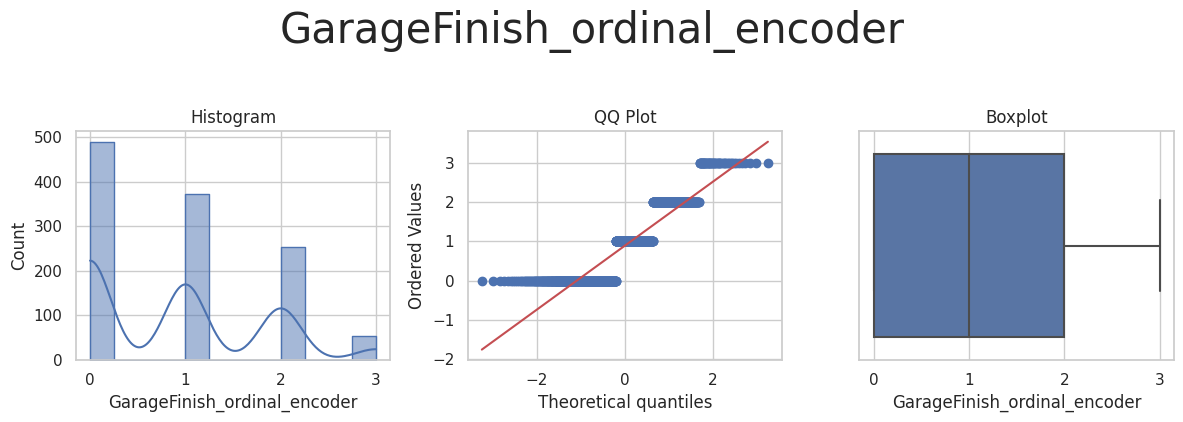



* Variable Analyzed: KitchenQual
* Applied transformation: ['KitchenQual_ordinal_encoder'] 



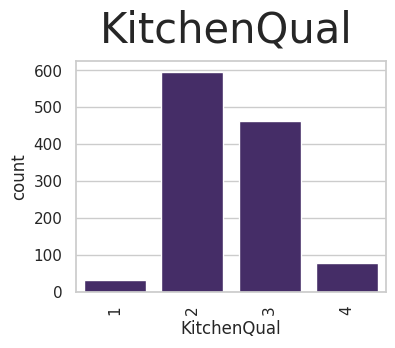

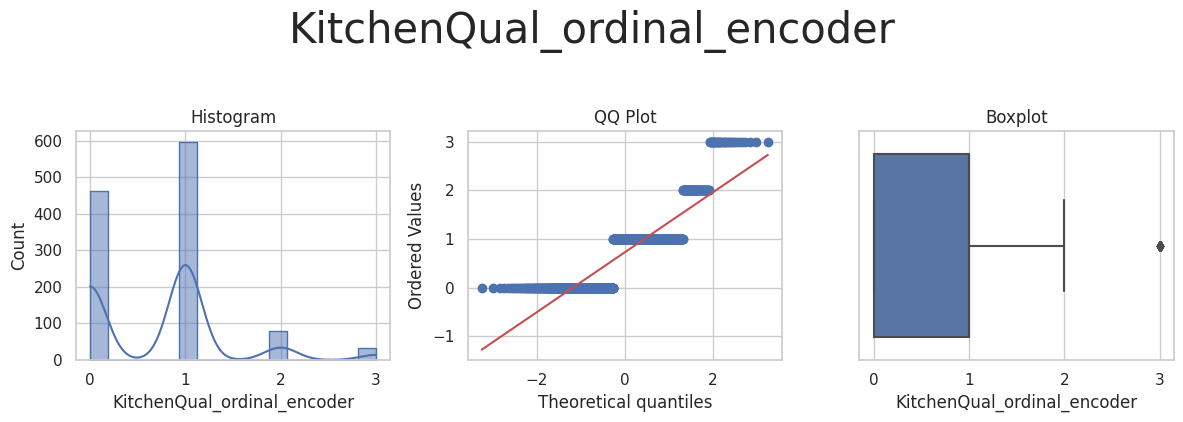



* Variable Analyzed: OverallCond
* Applied transformation: ['OverallCond_ordinal_encoder'] 



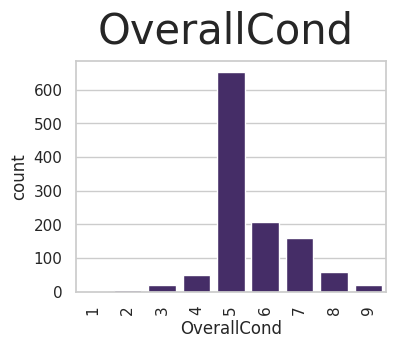

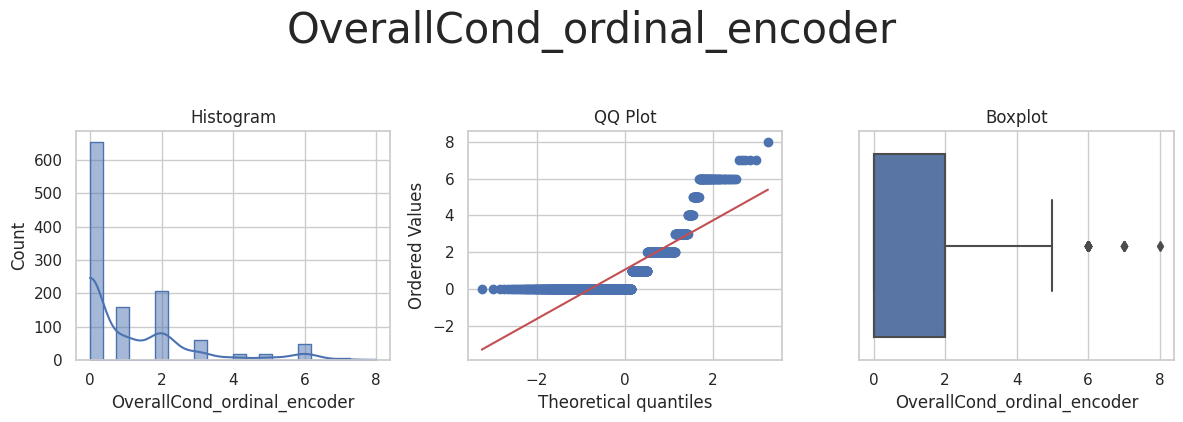



* Variable Analyzed: OverallQual
* Applied transformation: ['OverallQual_ordinal_encoder'] 



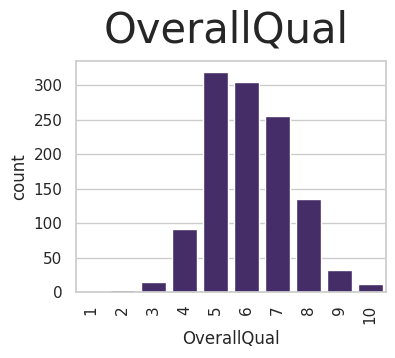

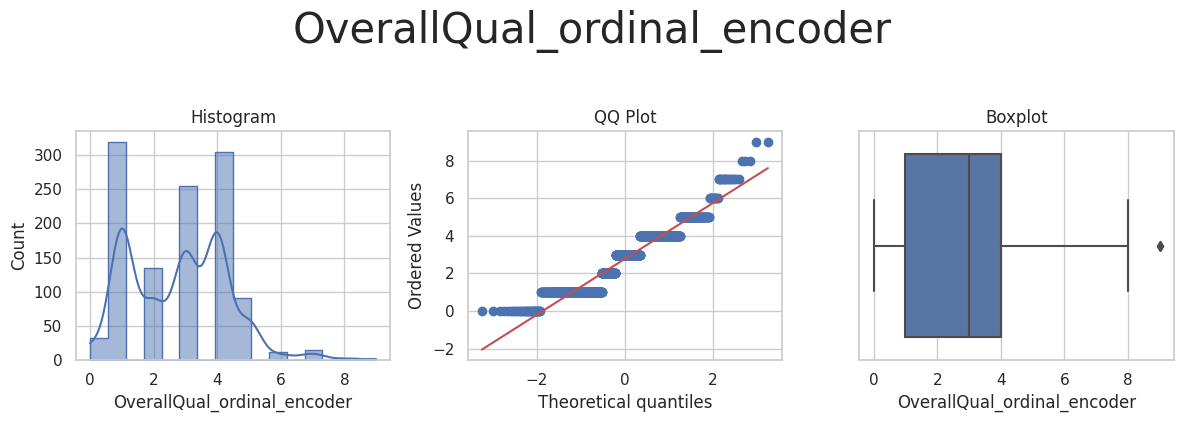



* Variable Analyzed: Has2ndFloor
* Applied transformation: ['Has2ndFloor_ordinal_encoder'] 



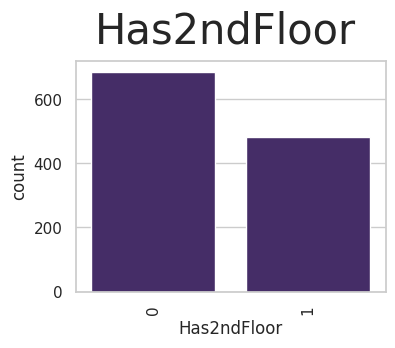

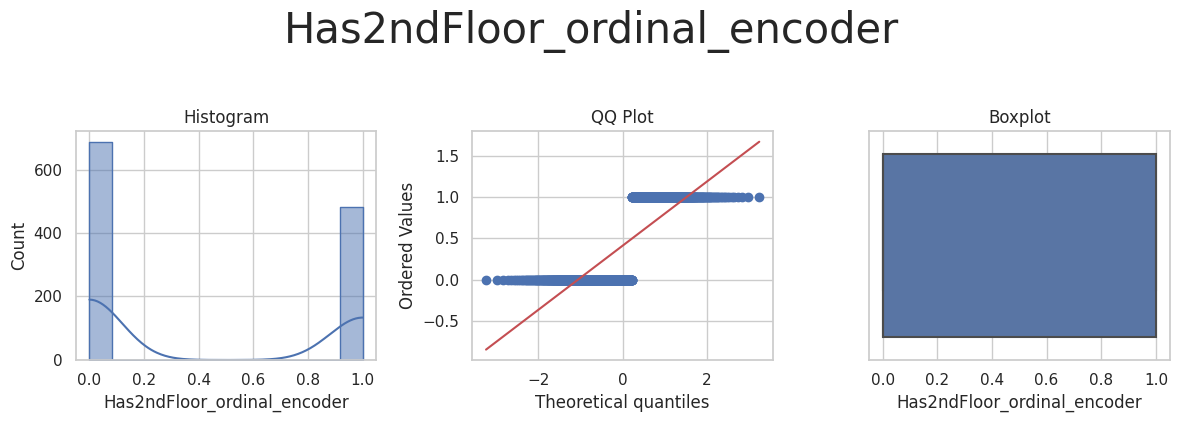



* Variable Analyzed: HasMasVnr
* Applied transformation: ['HasMasVnr_ordinal_encoder'] 



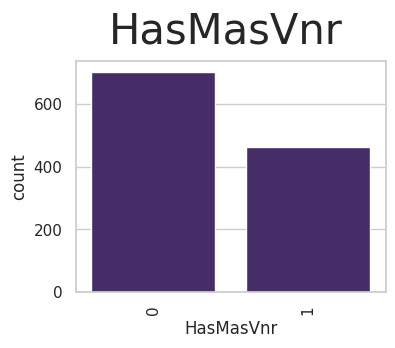

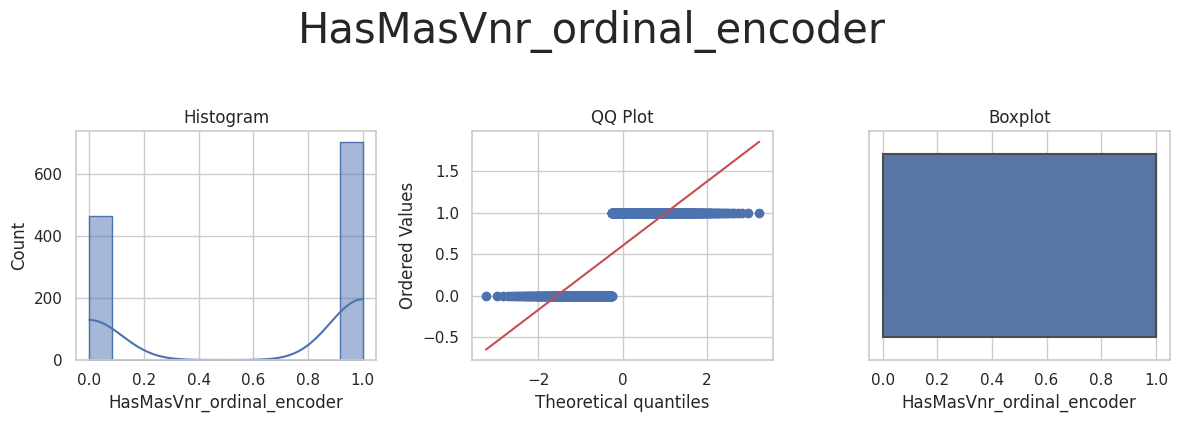



* Variable Analyzed: HasOpenPorch
* Applied transformation: ['HasOpenPorch_ordinal_encoder'] 



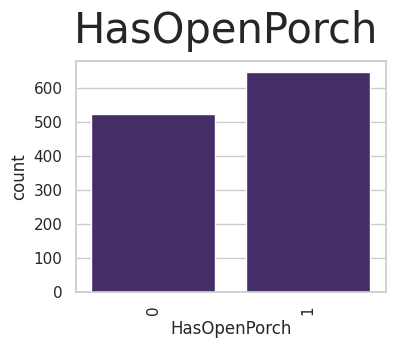

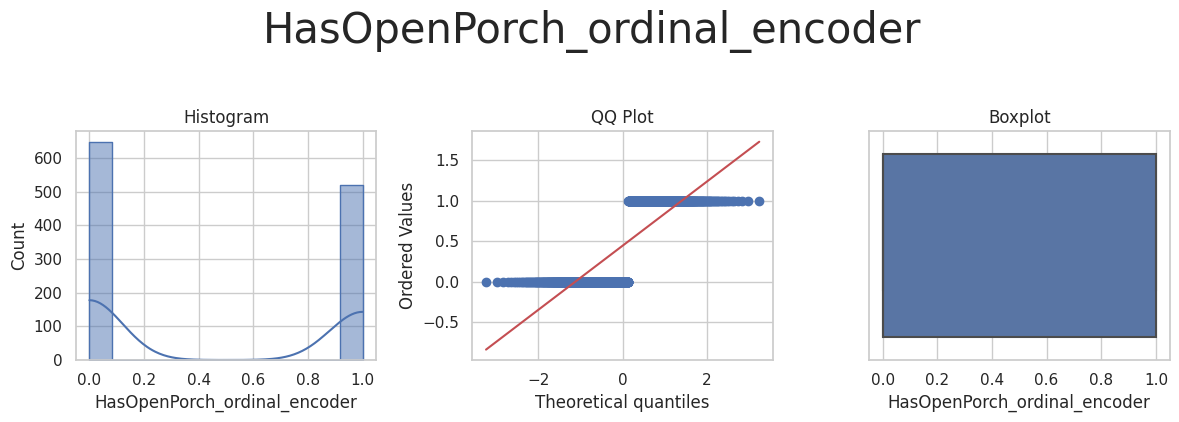



* Variable Analyzed: HasGarage
* Applied transformation: ['HasGarage_ordinal_encoder'] 



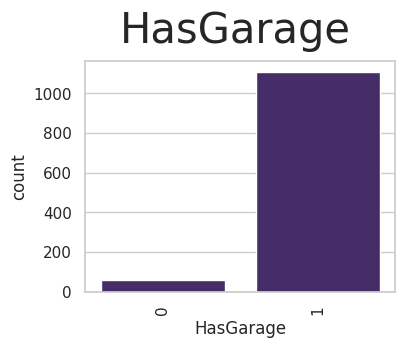

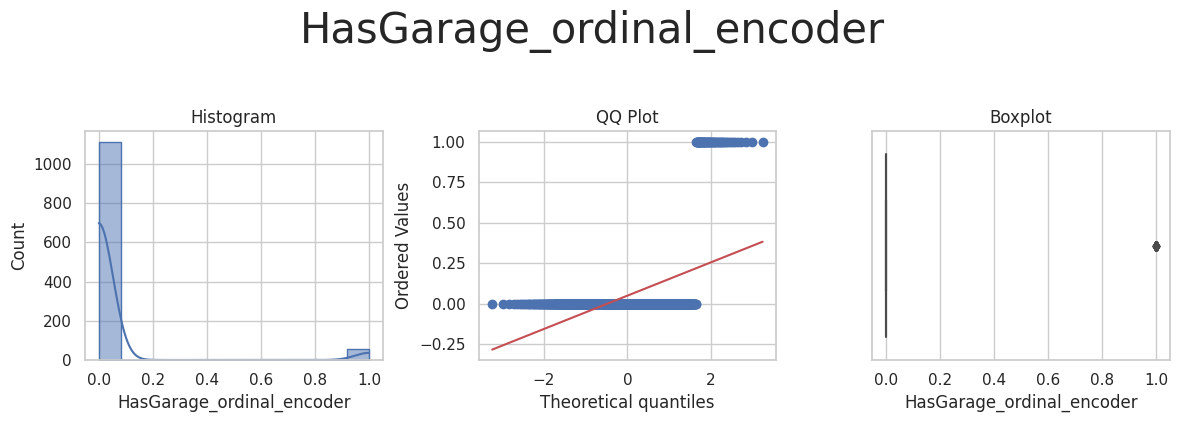



* Variable Analyzed: HasFinBsmt
* Applied transformation: ['HasFinBsmt_ordinal_encoder'] 



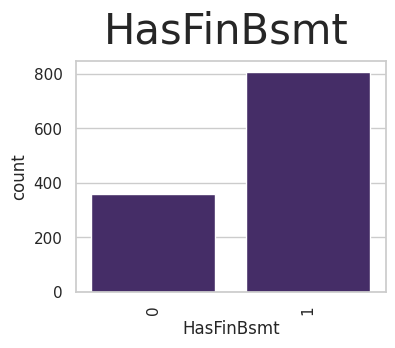

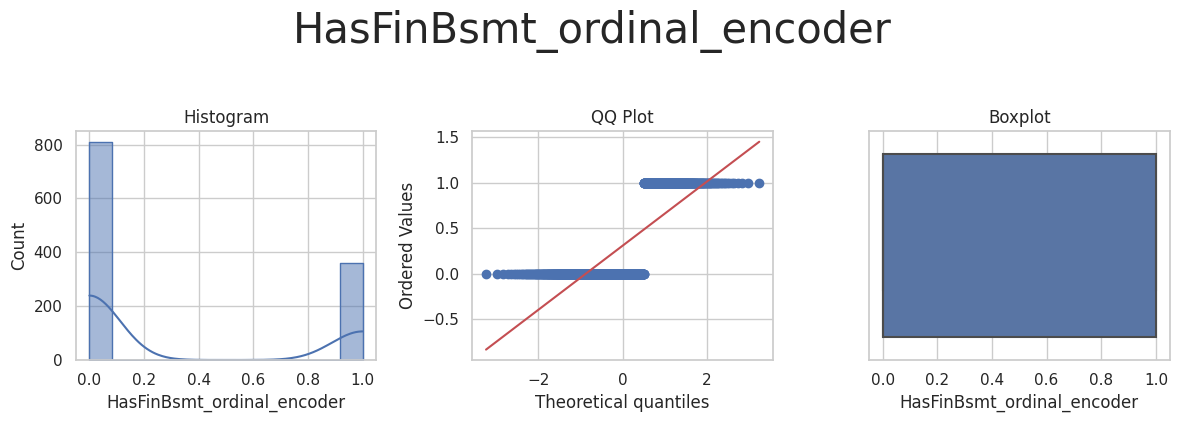



* Variable Analyzed: ModsMade
* Applied transformation: ['ModsMade_ordinal_encoder'] 



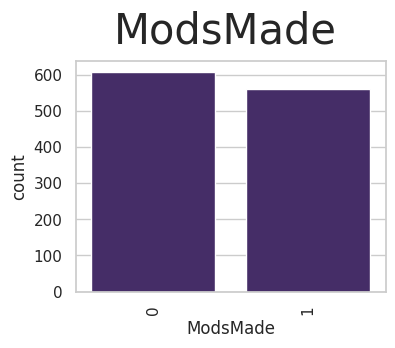

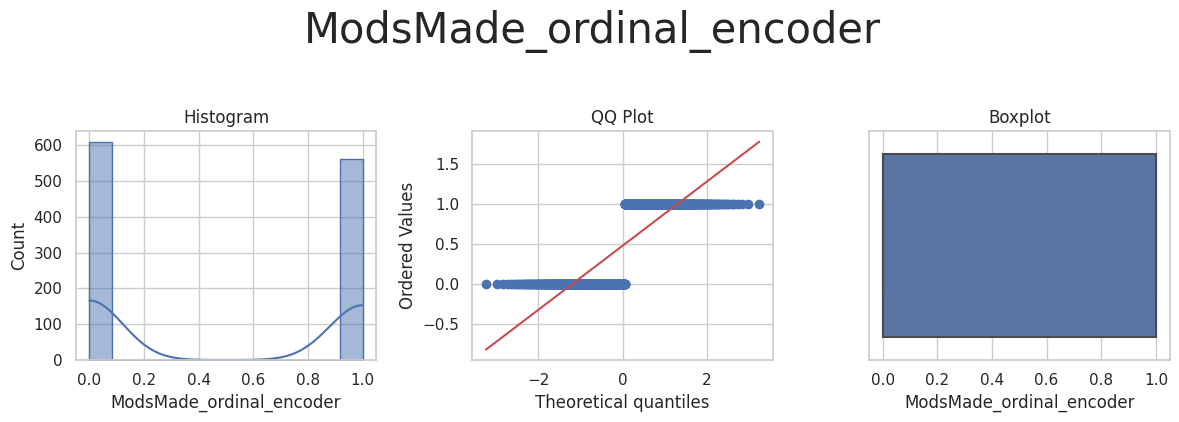

In [44]:
# Categorical encoding and transformations

variables_engineering= ['BsmtExposure', 'BsmtFinType1', 'GarageFinish',
            'KitchenQual', 'OverallCond', 'OverallQual',
            'Has2ndFloor', 'HasMasVnr', 'HasOpenPorch', 
            'HasGarage', 'HasFinBsmt', 'ModsMade']
variables_engineering

# Creating a separate DataFrame, with recoded variables
df_engineering = df[variables_engineering].copy()
df_engineering.head(3)

# Creating engineered variabless by applying the transformations, assessing engineered variables distribution 
# and selecting the most suitable method for each variable.
df_engineering = FeatureEngineeringAnalysis(df_engineering, analysis_type='ordinal_encoder')


# Applying the selected transformation to the Train and Test set
encoder = OrdinalEncoder(encoding_method='arbitrary', variables = variables_engineering)
TrainSet = encoder.fit_transform(TrainSet)
TestSet = encoder.transform(TestSet)


In [45]:
TrainSet.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1168 entries, 618 to 684
Data columns (total 22 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   1stFlrSF       1168 non-null   int64
 1   BedroomAbvGr   1168 non-null   int64
 2   BsmtExposure   1168 non-null   int64
 3   BsmtFinType1   1168 non-null   int64
 4   GarageFinish   1168 non-null   int64
 5   GarageYrBlt    1168 non-null   int64
 6   GrLivArea      1168 non-null   int64
 7   KitchenQual    1168 non-null   int64
 8   LotArea        1168 non-null   int64
 9   LotFrontage    1168 non-null   int64
 10  OverallCond    1168 non-null   int64
 11  OverallQual    1168 non-null   int64
 12  TotalBsmtSF    1168 non-null   int64
 13  YearBuilt      1168 non-null   int64
 14  SalePrice      1168 non-null   int64
 15  Has2ndFloor    1168 non-null   int64
 16  HasMasVnr      1168 non-null   int64
 17  HasOpenPorch   1168 non-null   int64
 18  HasGarage      1168 non-null   int64
 19  HasFi

In [46]:
# List of columns with potential outliers
vars_with_outliers = [
    '1stFlrSF', 'BedroomAbvGr', 'GarageYrBlt',
    'GrLivArea', 'LotArea', 'LotFrontage',
    'TotalBsmtSF', 'YearBuilt'
]

# Apply Winsorization on TrainSet
# Create a separate DataFrame with selected variables for TrainSet
df_train_outliers = TrainSet[vars_with_outliers].copy()

# Apply the Winsorizer function to TrainSet
df_train_winsorized, methods_applied_train = FeatEngineering_OutlierWinsorizer(df_train_outliers, columns=vars_with_outliers)

# Apply Winsorization on TestSet
# Create a separate DataFrame with selected variables for TestSet
df_test_outliers = TestSet[vars_with_outliers].copy()

# Apply the Winsorizer function to TestSet
df_test_winsorized, methods_applied_test = FeatEngineering_OutlierWinsorizer(df_test_outliers, columns=vars_with_outliers)

# Display the first few rows to verify
print("TrainSet Winsorized:\n", df_train_winsorized.head(3))
print("\nTestSet Winsorized:\n", df_test_winsorized.head(3))
print("Methods Applied Train:", methods_applied_train, "Methods Applied Test:", methods_applied_test)


TrainSet Winsorized:
      1stFlrSF  BedroomAbvGr  GarageYrBlt  GrLivArea  LotArea  LotFrontage  \
618    1828.0           3.0       2007.0     1828.0  11694.0         90.0   
870     894.0           2.0       1962.0      894.0   6600.0         60.0   
92      964.0           2.0       1921.0      964.0  13360.0         80.0   

     TotalBsmtSF  YearBuilt  
618       1822.0     2007.0  
870        894.0     1962.0  
92         876.0     1921.0  

TestSet Winsorized:
      1stFlrSF  BedroomAbvGr  GarageYrBlt  GrLivArea    LotArea  LotFrontage  \
529   2190.25           4.0       1975.0     2515.0  17695.875         80.0   
491    958.00           3.0       1941.0     1578.0   9490.000         79.0   
459    979.00           3.0       1950.0     1203.0   7015.000        110.0   

     TotalBsmtSF  YearBuilt  
529       2035.0     1957.0  
491        806.0     1941.0  
459        709.0     1950.0  
Methods Applied Train: ['1stFlrSF_iqr', 'BedroomAbvGr_iqr', 'GarageYrBlt_iqr', 'GrLivArea_

In [48]:
# Original dataset summary stats
original_data_for_outliers = TrainSet[['1stFlrSF', 'BedroomAbvGr', 'GarageYrBlt', 'GrLivArea', 'LotArea', 'LotFrontage', 'TotalBsmtSF', 'YearBuilt']].describe()
original_data_for_outliers

1stFlrSF  BedroomAbvGr  GarageYrBlt    GrLivArea        LotArea  \
count  1168.000000   1168.000000  1168.000000  1168.000000    1168.000000   
mean   1160.958904      2.883562  1976.326199  1518.882705   10589.672945   
std     373.315037      0.820770    26.273277   513.800708   10704.180793   
min     334.000000      0.000000  1872.000000   334.000000    1300.000000   
25%     884.000000      2.000000  1959.000000  1139.000000    7589.500000   
50%    1092.000000      3.000000  1977.000000  1471.500000    9512.500000   
75%    1389.250000      3.000000  2001.000000  1788.500000   11601.500000   
max    3228.000000      8.000000  2010.000000  4676.000000  215245.000000   

       LotFrontage  TotalBsmtSF    YearBuilt  
count  1168.000000  1168.000000  1168.000000  
mean     69.655822  1053.511986  1970.890411  
std      22.748459   412.073393    30.407486  
min      21.000000     0.000000  1872.000000  
25%      59.000000   798.750000  1953.750000  
50%      69.000000   992.000000  1972.000000  
75%      80.000000  1276.250000  2000.000000  
max     313.000000  3206.000000  2010.000000

In [49]:
# Writing the Winsorized variables into the dataframe
TrainSet[vars_with_outliers] = df_train_winsorized
TestSet[vars_with_outliers] = df_test_winsorized

In [50]:
outlier_summary_stats = TrainSet[vars_with_outliers].describe()
outlier_summary_stats

1stFlrSF  BedroomAbvGr  GarageYrBlt    GrLivArea       LotArea  \
count  1168.000000   1168.000000  1168.000000  1168.000000   1168.000000   
mean   1157.063891      2.866438  1976.364726  1509.476027   9646.455908   
std     358.990145      0.755536    26.138426   481.348711   3561.534341   
min     334.000000      0.500000  1896.000000   334.000000   1571.500000   
25%     884.000000      2.000000  1959.000000  1139.000000   7589.500000   
50%    1092.000000      3.000000  1977.000000  1471.500000   9512.500000   
75%    1389.250000      3.000000  2001.000000  1788.500000  11601.500000   
max    2147.125000      4.500000  2010.000000  2762.750000  17619.500000   

       LotFrontage  TotalBsmtSF    YearBuilt  
count  1168.000000  1168.000000  1168.000000  
mean     68.976027  1049.327055  1970.924015  
std      19.309832   386.601452    30.307134  
min      27.500000    82.500000  1884.375000  
25%      59.000000   798.750000  1953.750000  
50%      69.000000   992.000000  1972.000000  
75%      80.000000  1276.250000  2000.000000  
max     111.500000  1992.500000  2010.000000

* Variable Analyzed: 1stFlrSF
* Applied transformation: ['1stFlrSF_log_e', '1stFlrSF_log_10', '1stFlrSF_reciprocal', '1stFlrSF_power', '1stFlrSF_box_cox', '1stFlrSF_yeo_johnson'] 



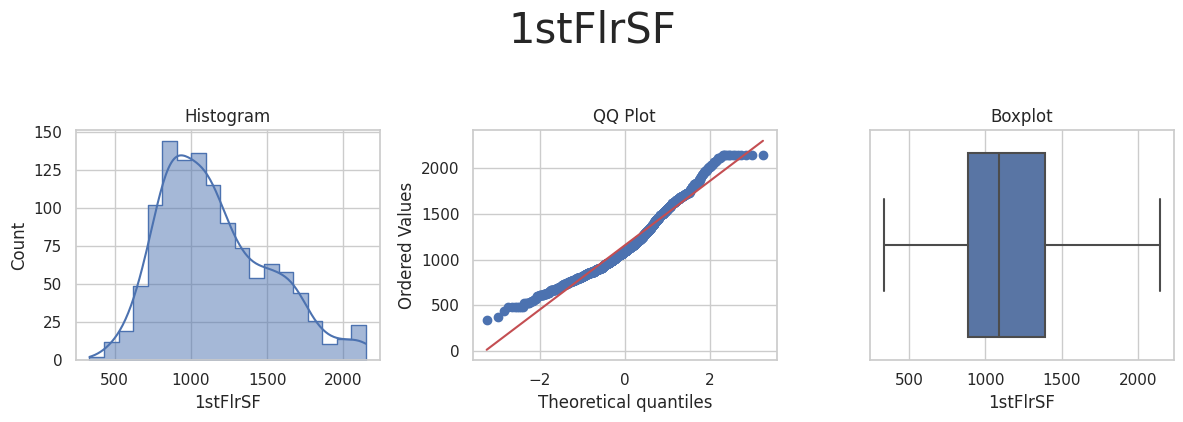

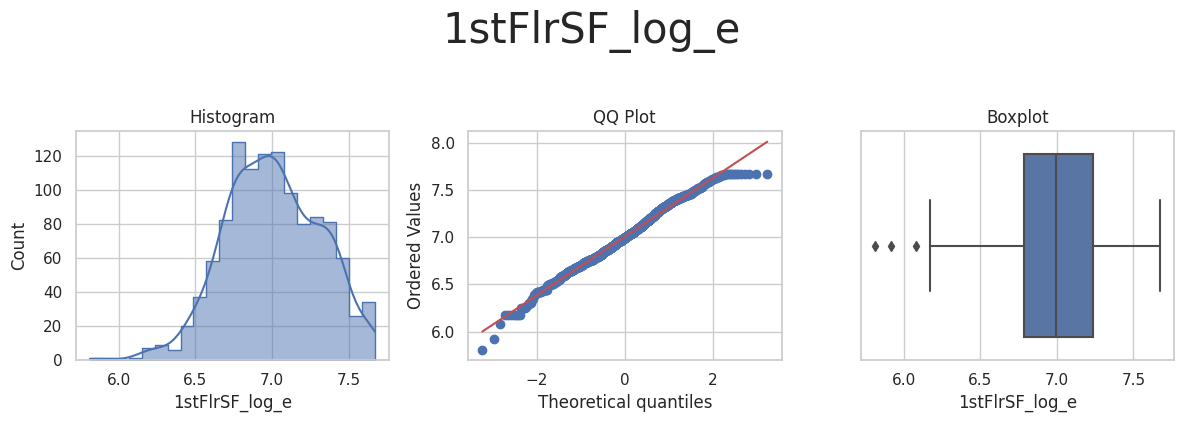

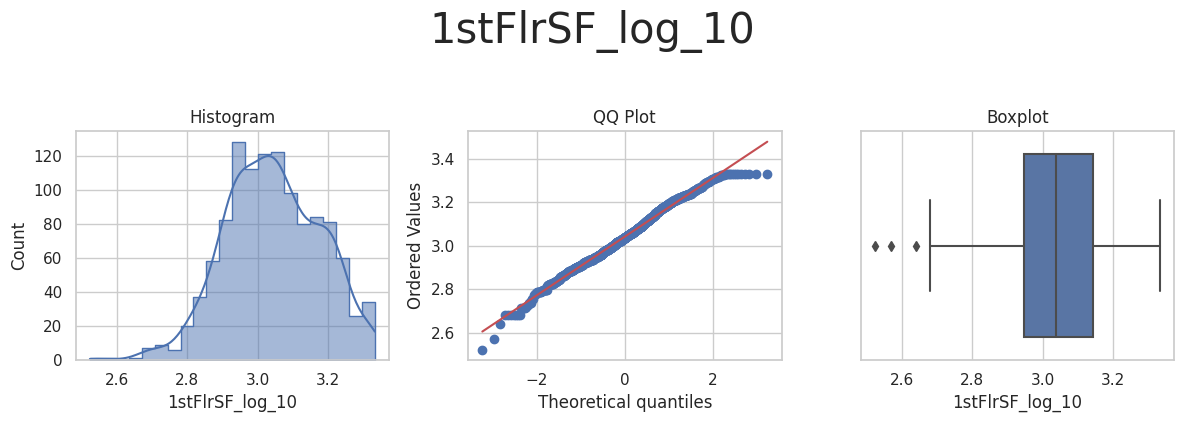

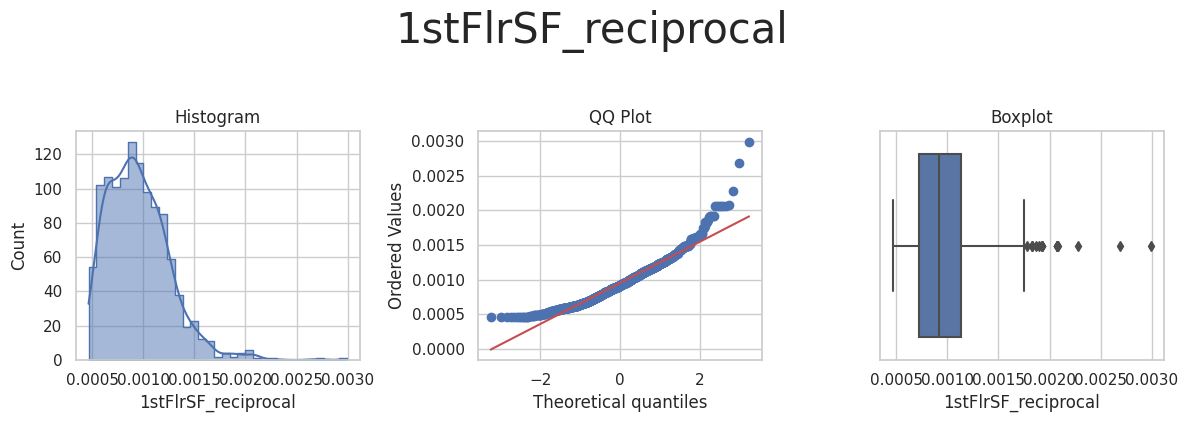

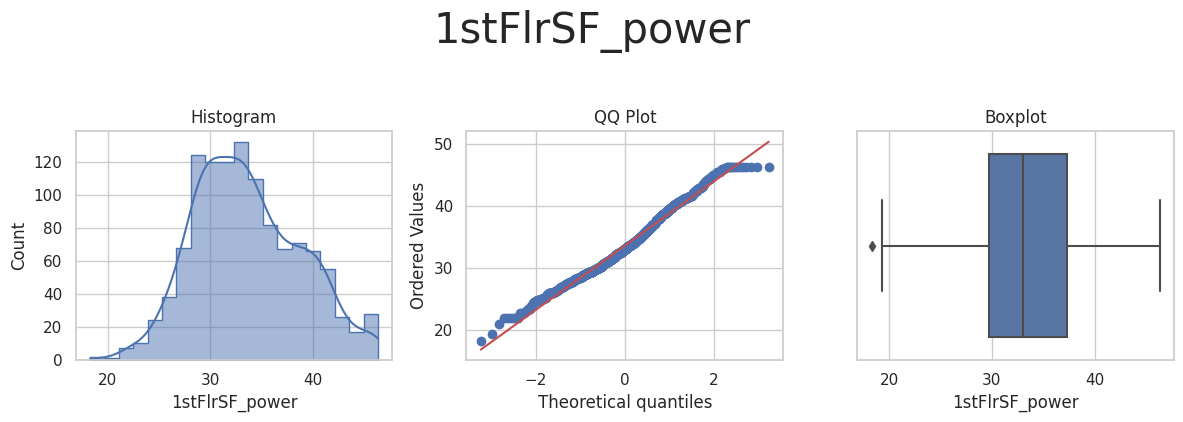

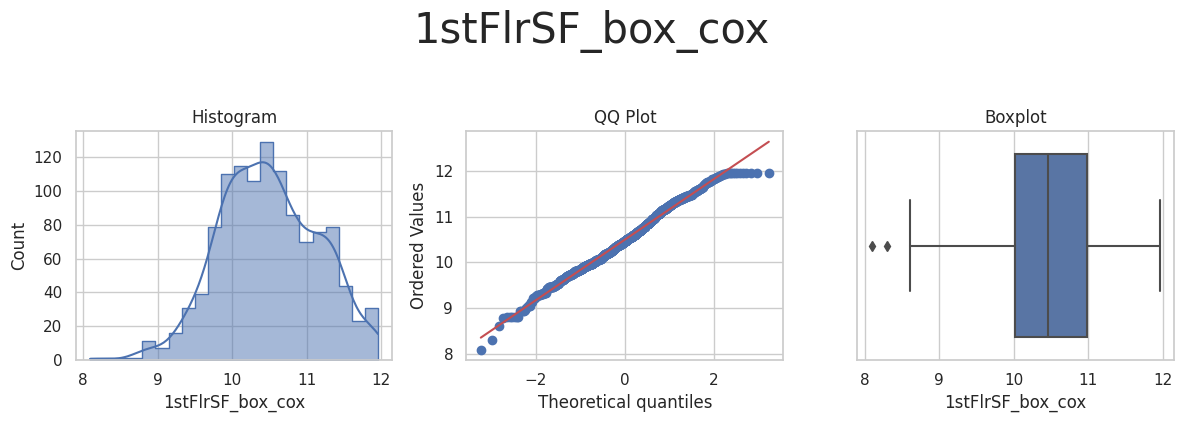

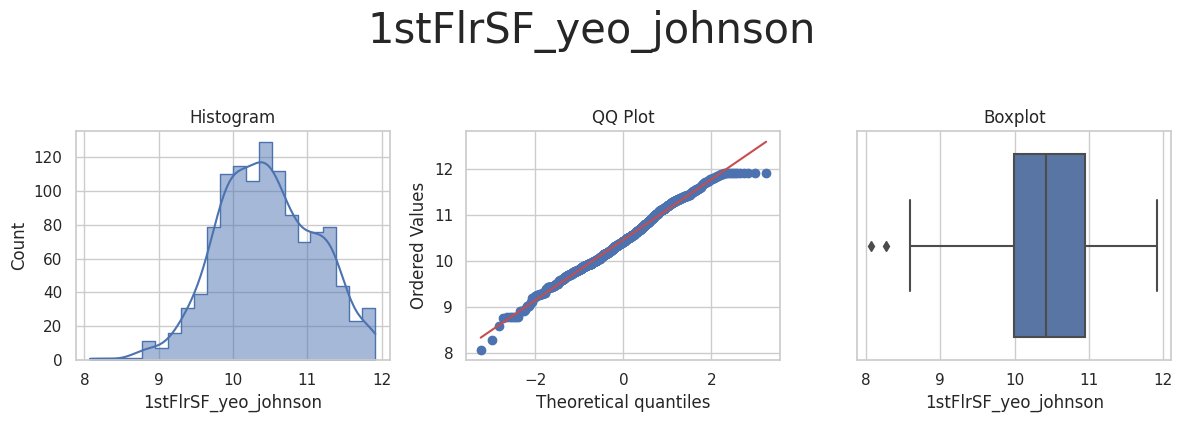



* Variable Analyzed: BedroomAbvGr
* Applied transformation: ['BedroomAbvGr_log_e', 'BedroomAbvGr_log_10', 'BedroomAbvGr_reciprocal', 'BedroomAbvGr_power', 'BedroomAbvGr_box_cox', 'BedroomAbvGr_yeo_johnson'] 



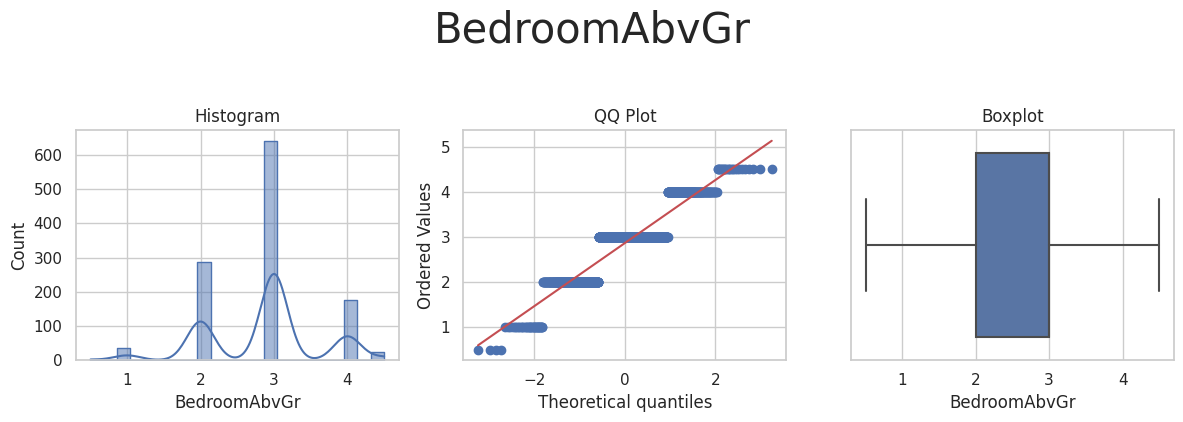

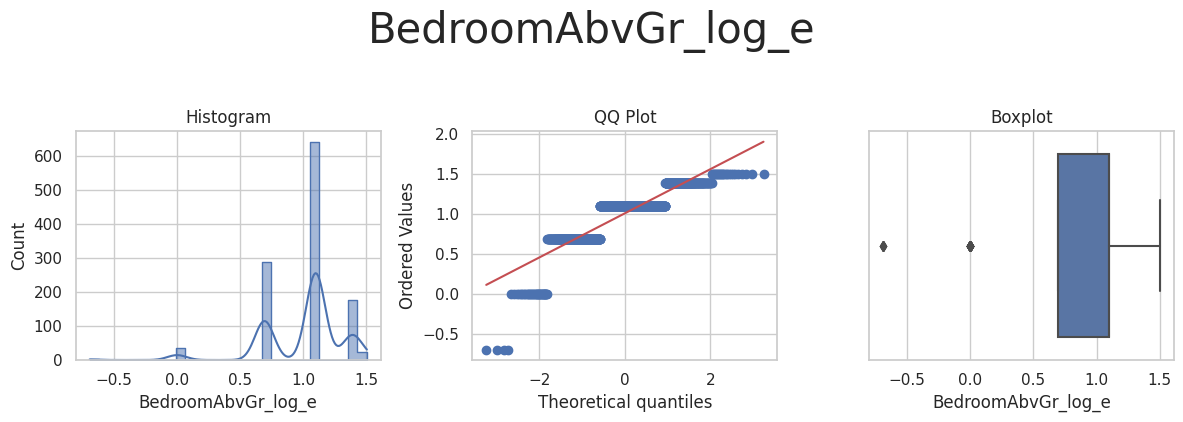

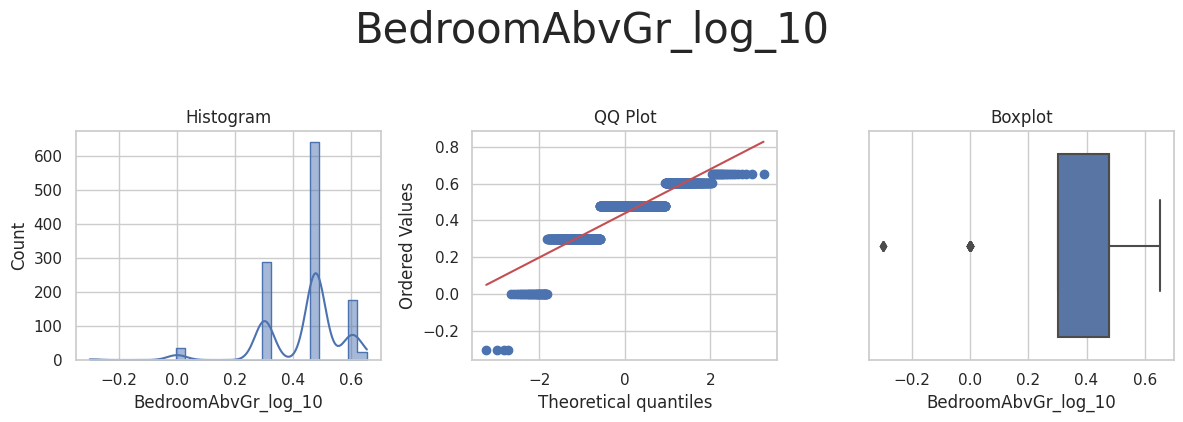

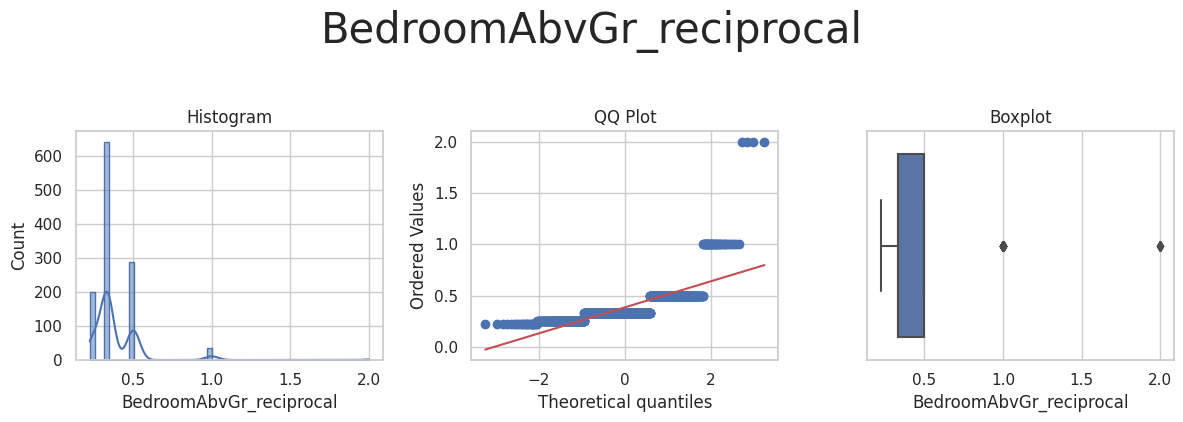

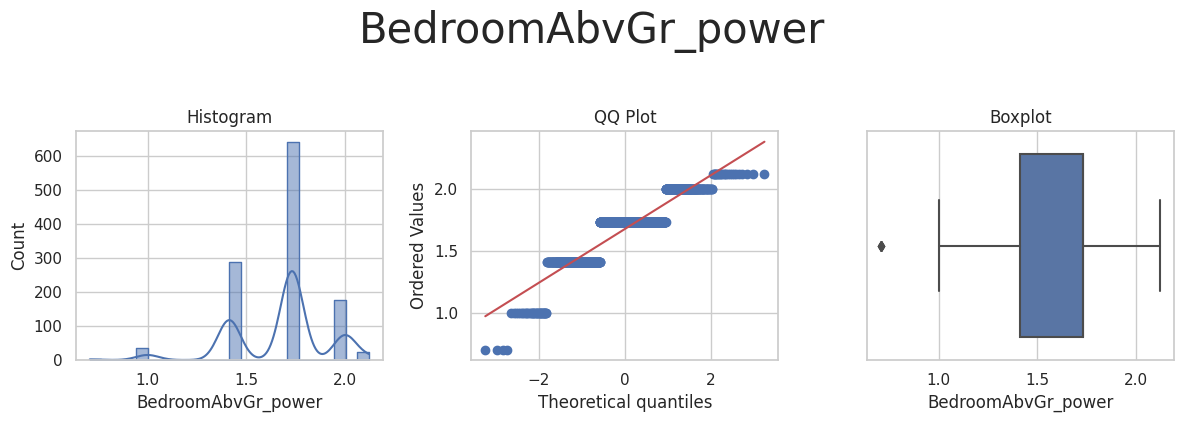

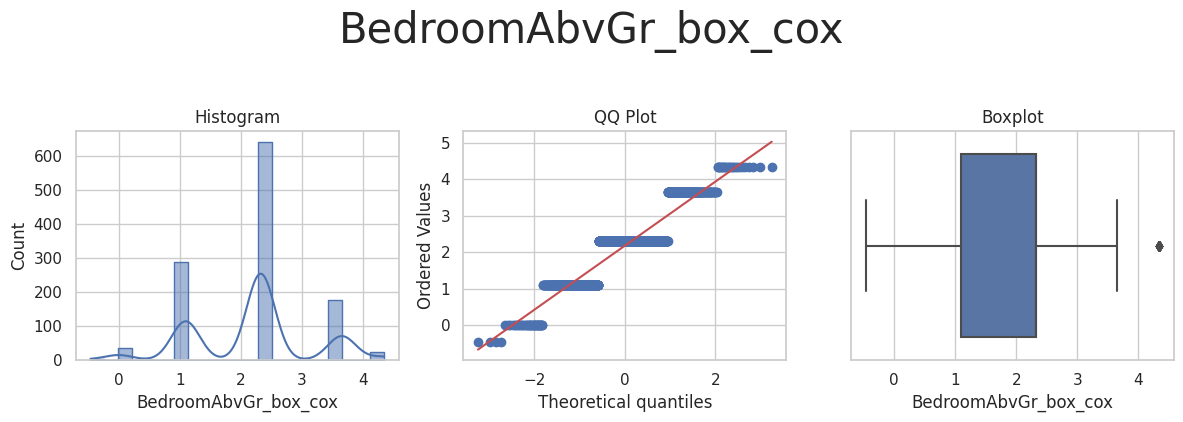

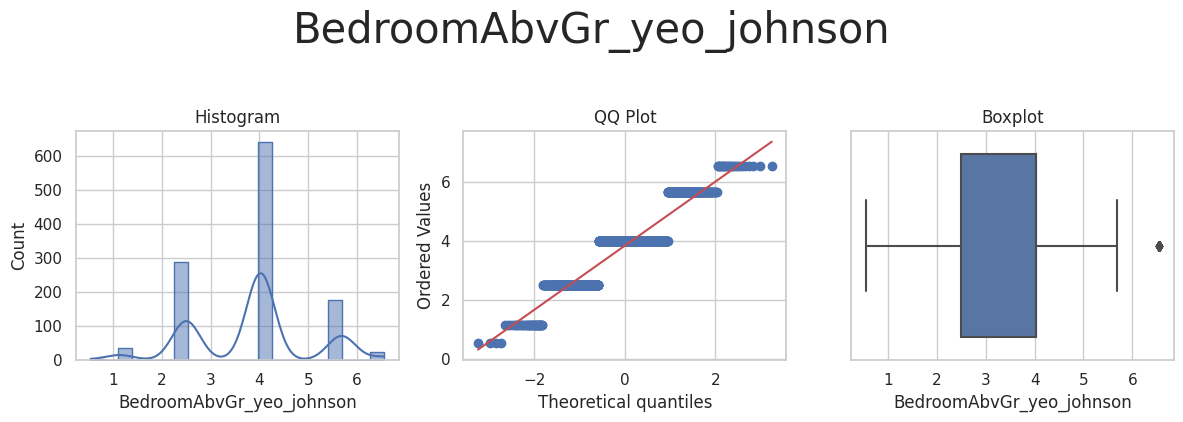



* Variable Analyzed: GarageYrBlt
* Applied transformation: ['GarageYrBlt_log_e', 'GarageYrBlt_log_10', 'GarageYrBlt_reciprocal', 'GarageYrBlt_power', 'GarageYrBlt_box_cox', 'GarageYrBlt_yeo_johnson'] 



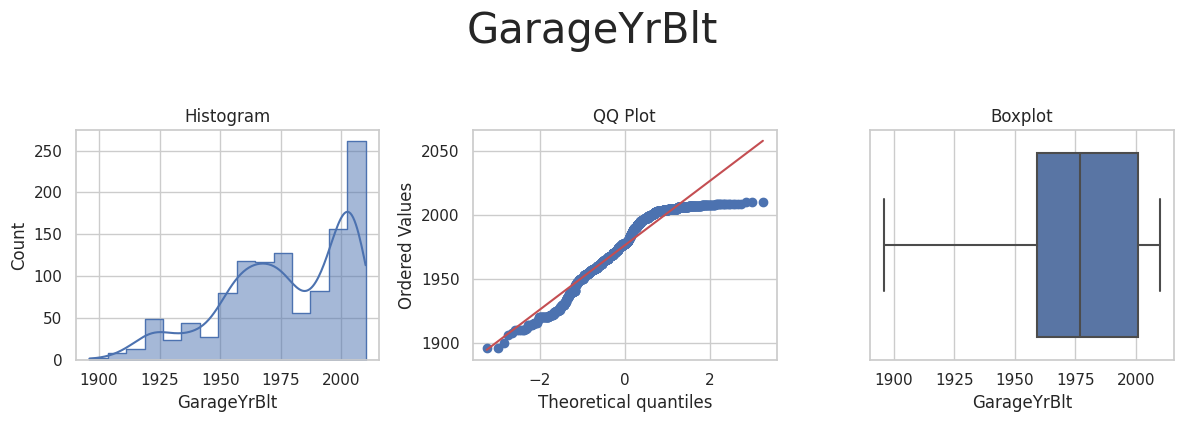

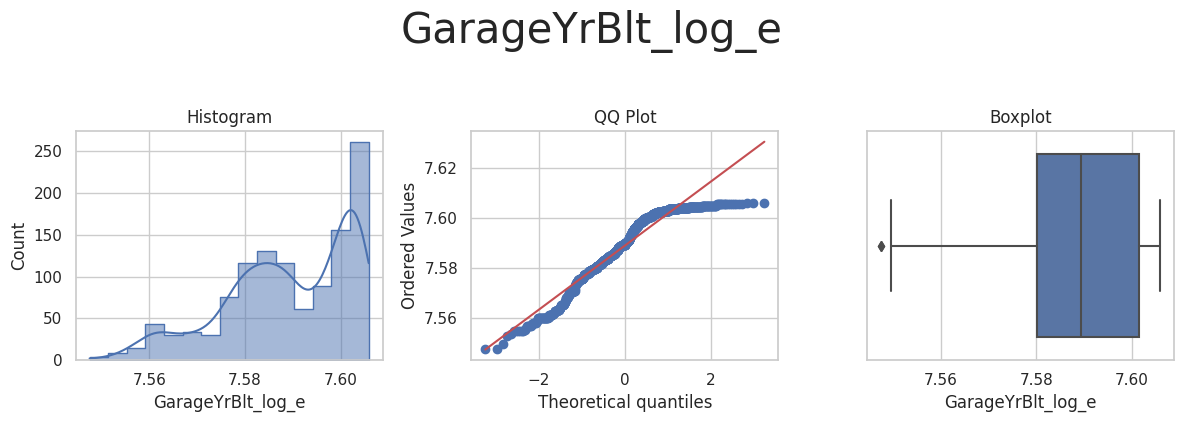

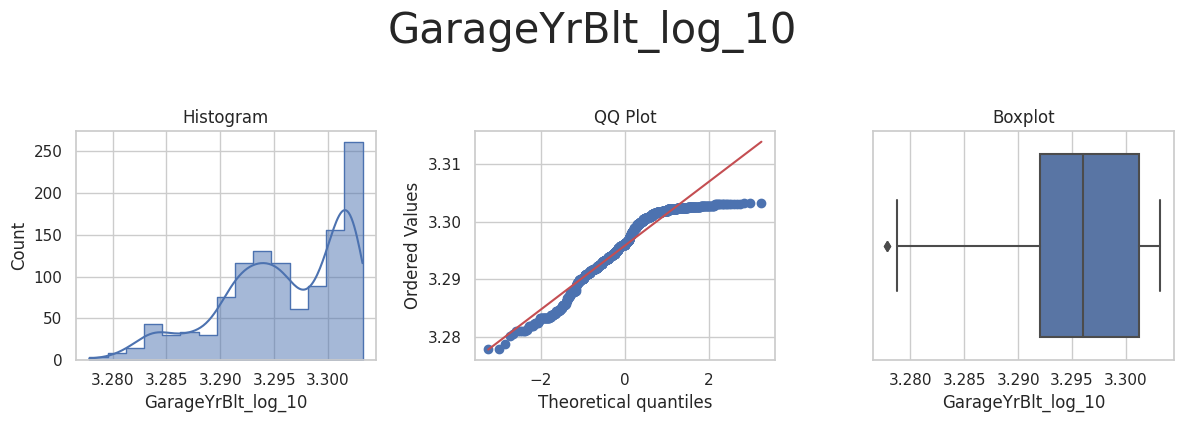

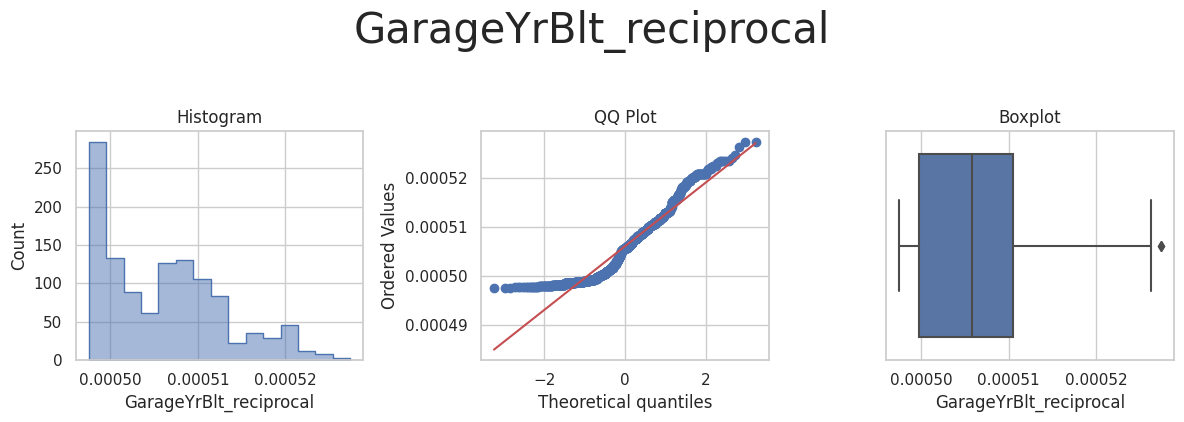

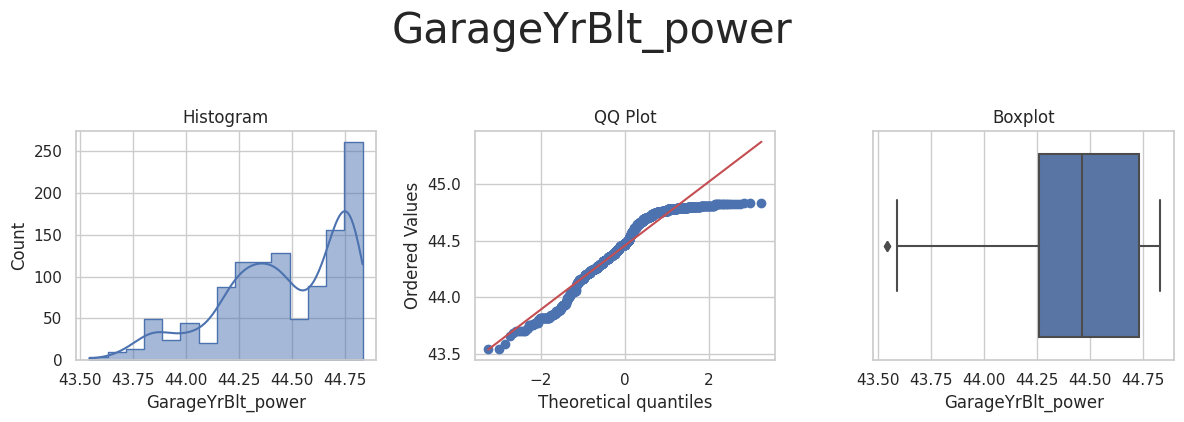

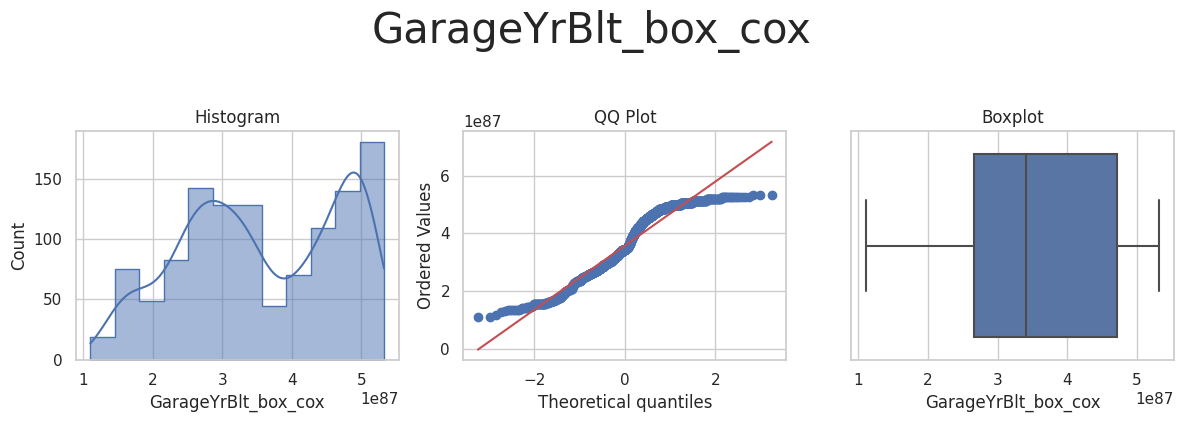

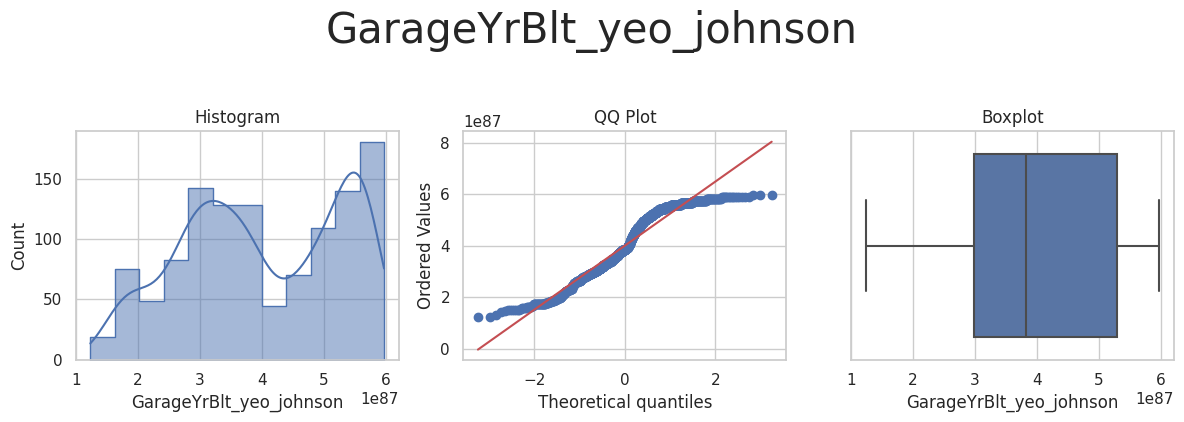



* Variable Analyzed: GrLivArea
* Applied transformation: ['GrLivArea_log_e', 'GrLivArea_log_10', 'GrLivArea_reciprocal', 'GrLivArea_power', 'GrLivArea_box_cox', 'GrLivArea_yeo_johnson'] 



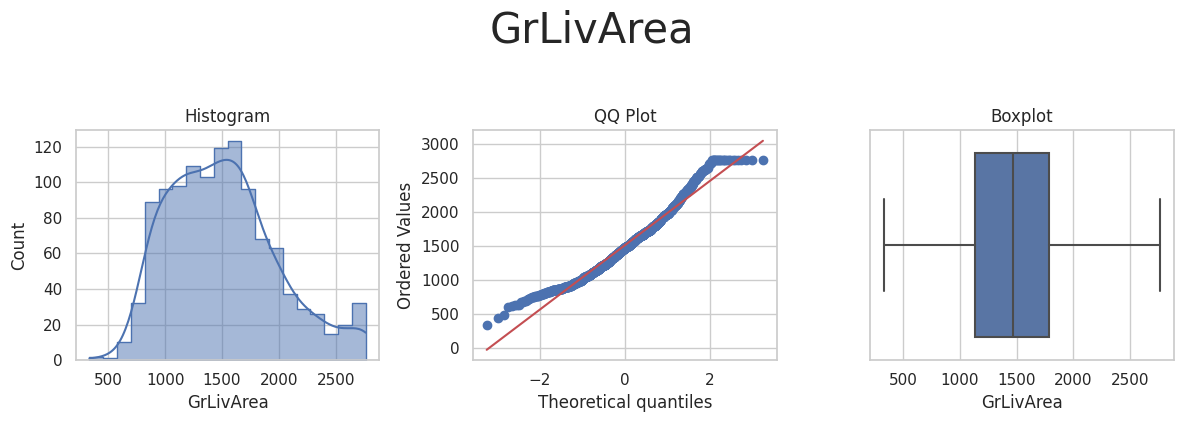

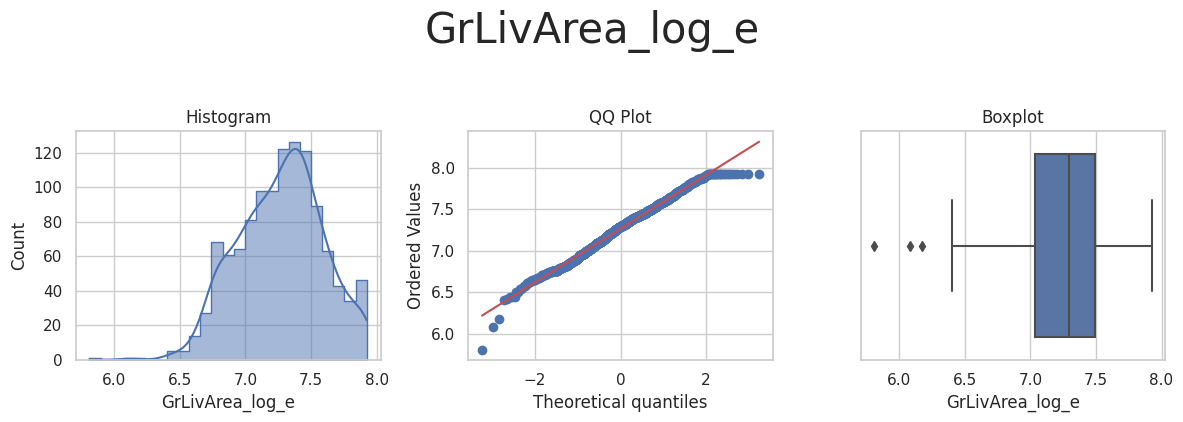

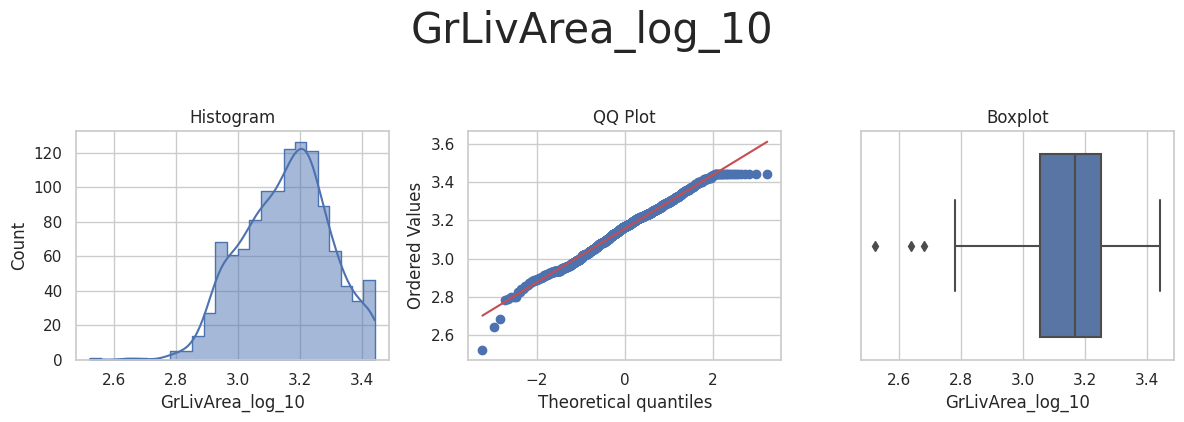

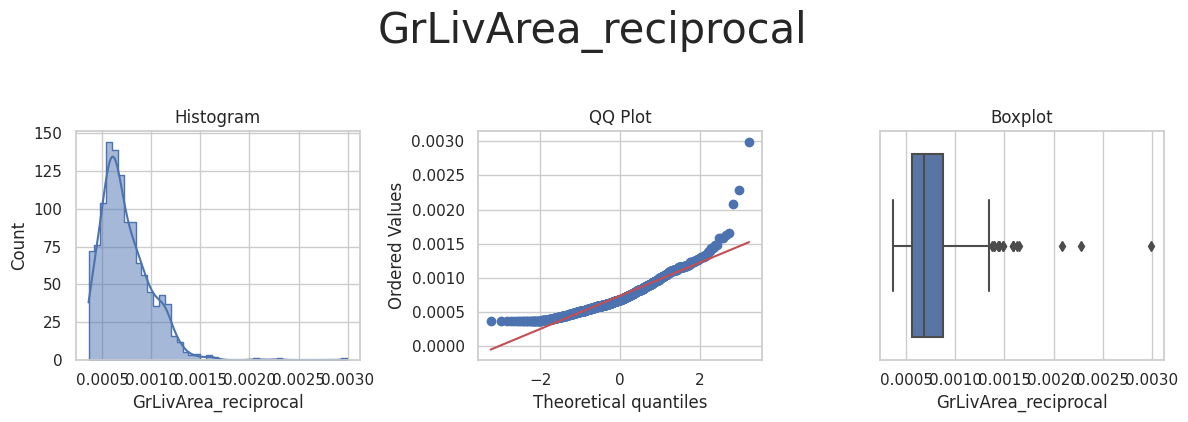

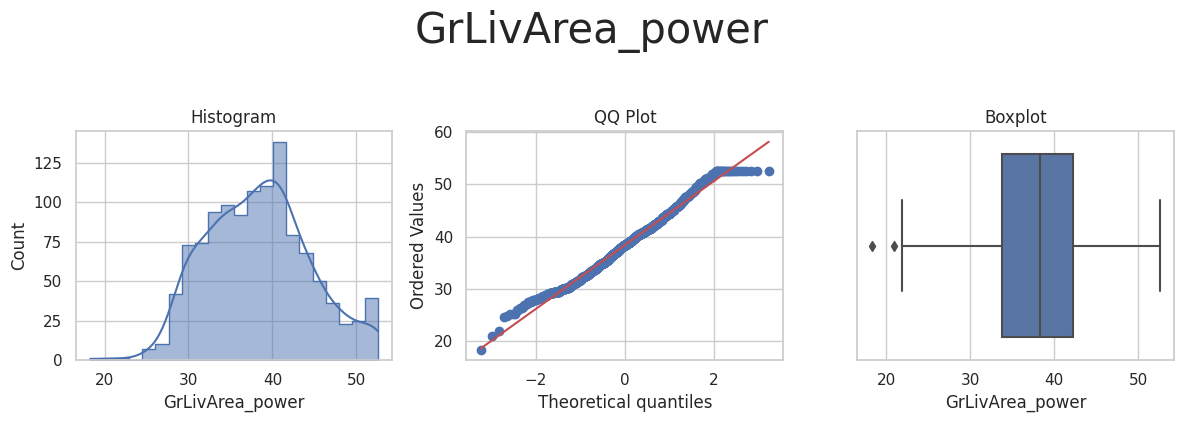

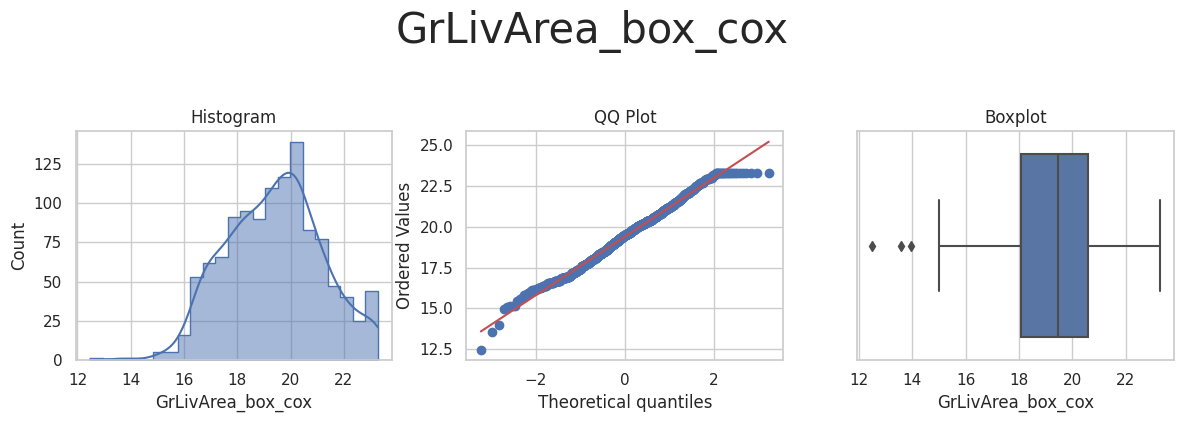

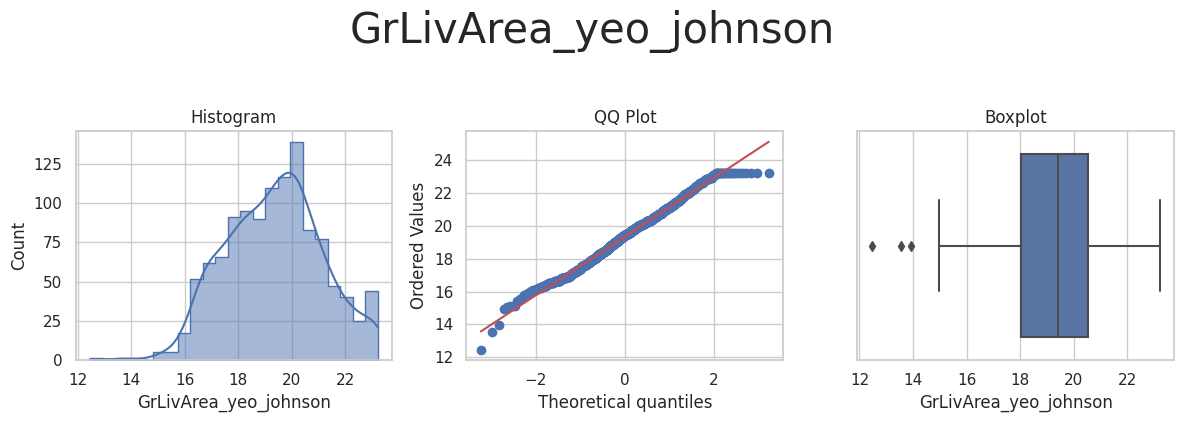



* Variable Analyzed: LotArea
* Applied transformation: ['LotArea_log_e', 'LotArea_log_10', 'LotArea_reciprocal', 'LotArea_power', 'LotArea_box_cox', 'LotArea_yeo_johnson'] 



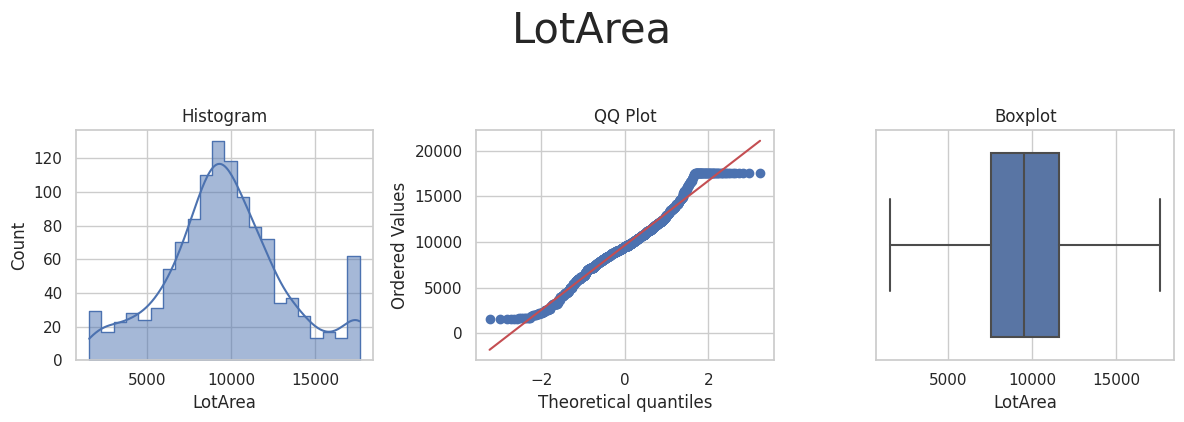

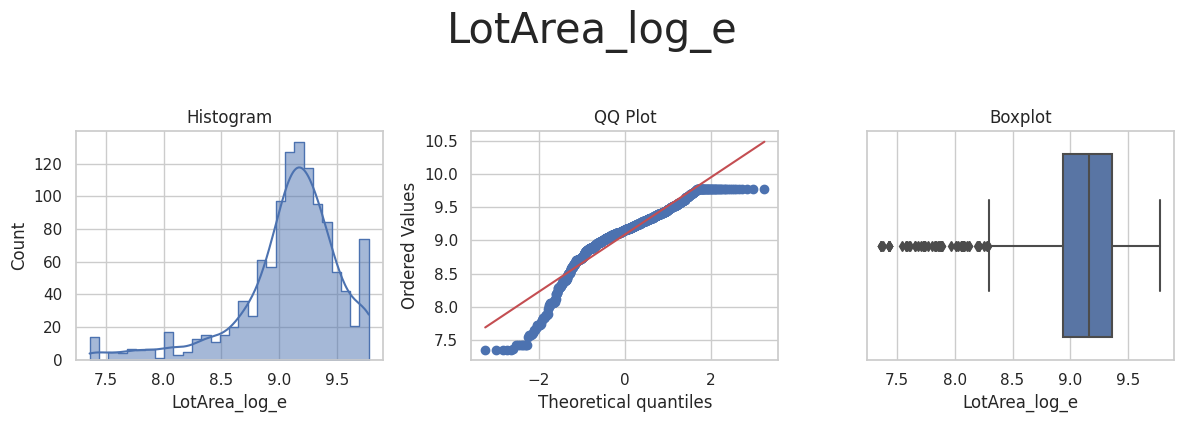

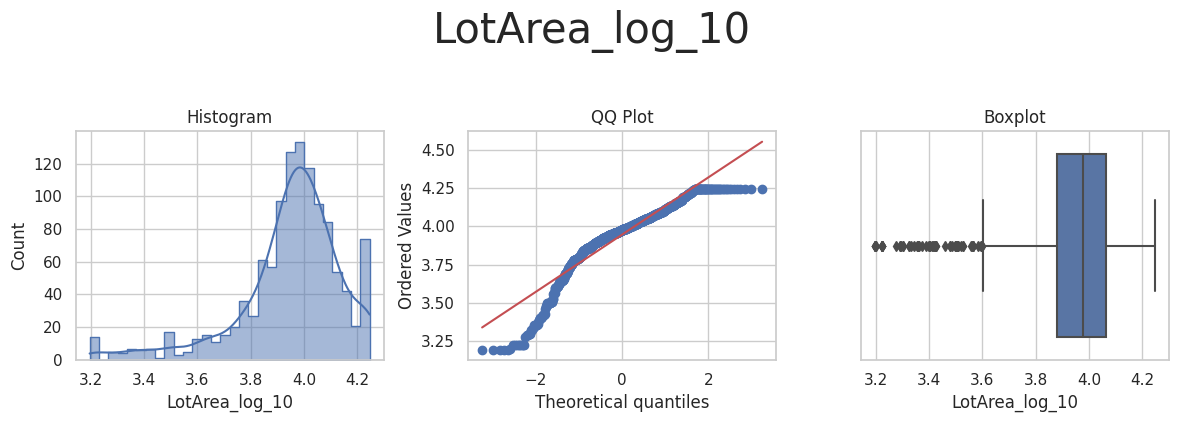

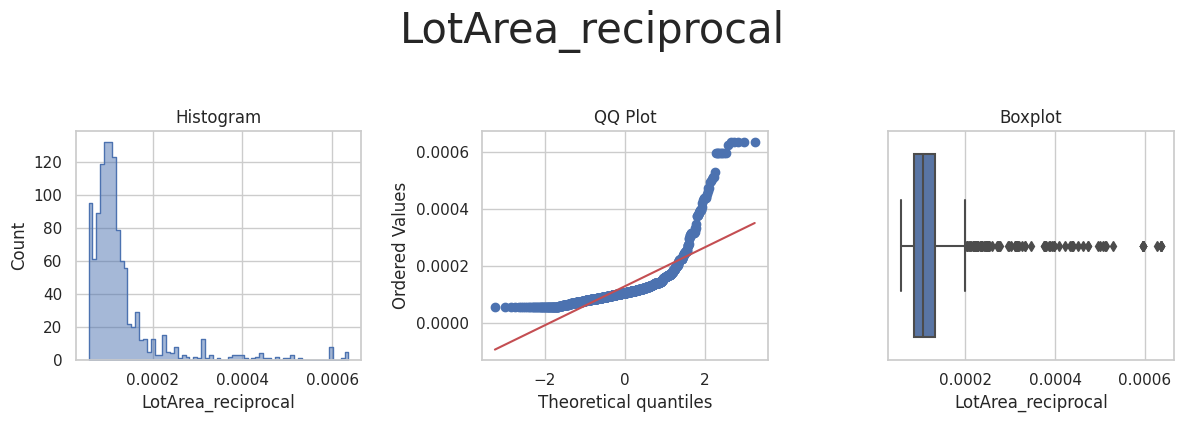

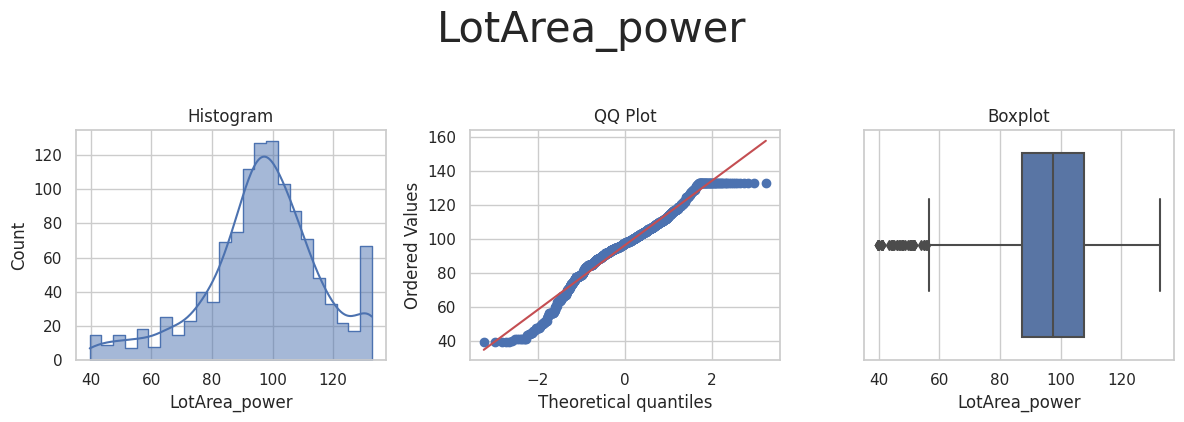

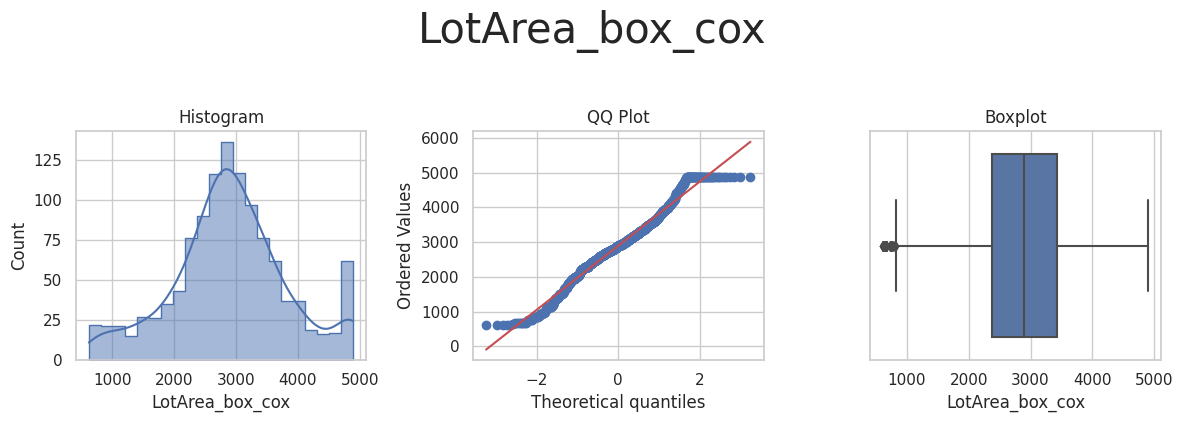

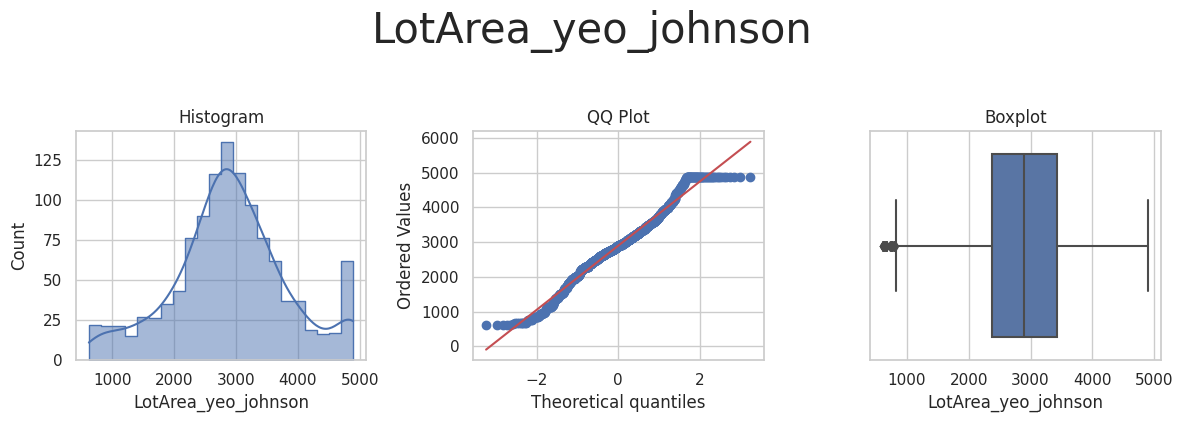



* Variable Analyzed: LotFrontage
* Applied transformation: ['LotFrontage_log_e', 'LotFrontage_log_10', 'LotFrontage_reciprocal', 'LotFrontage_power', 'LotFrontage_box_cox', 'LotFrontage_yeo_johnson'] 



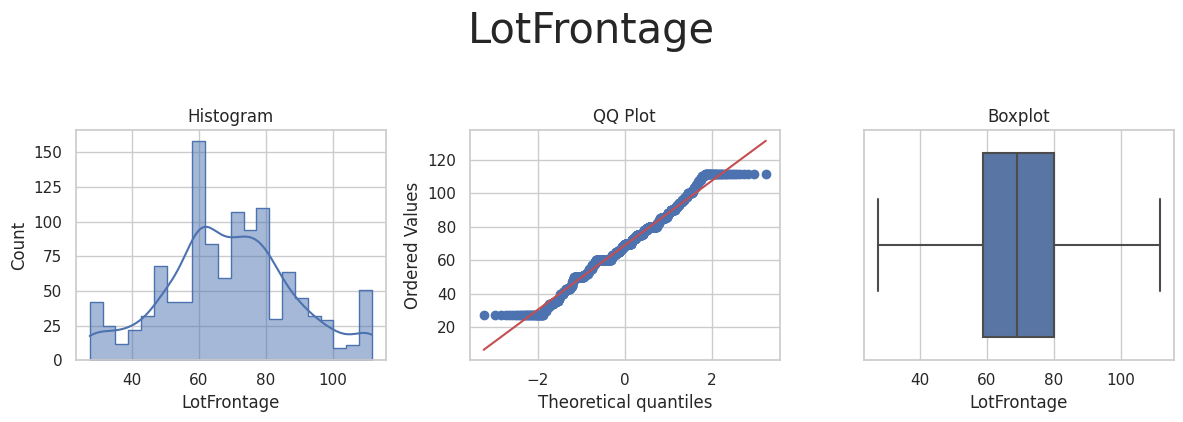

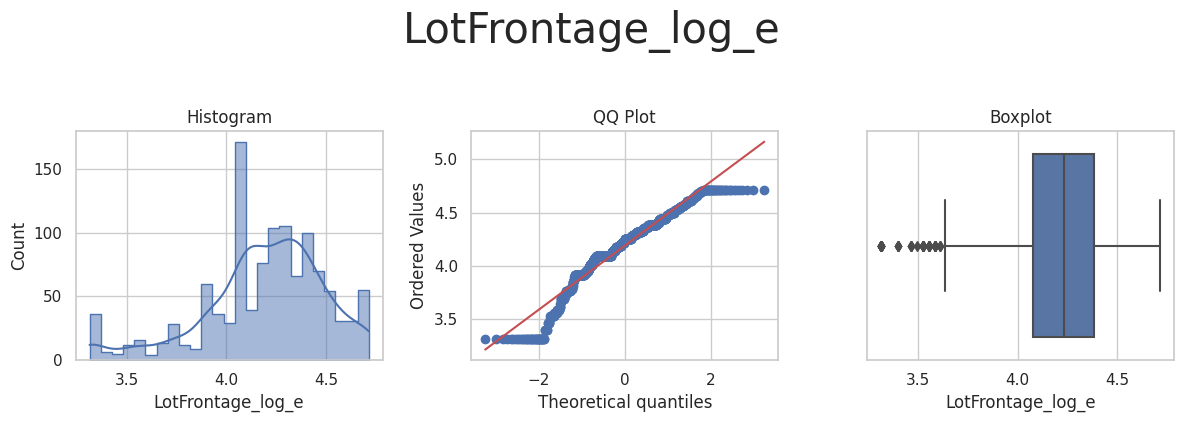

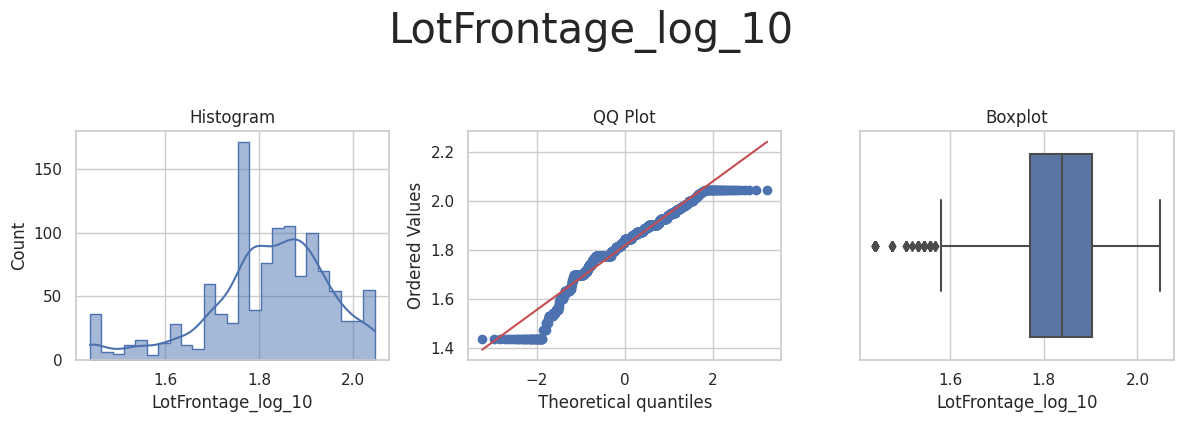

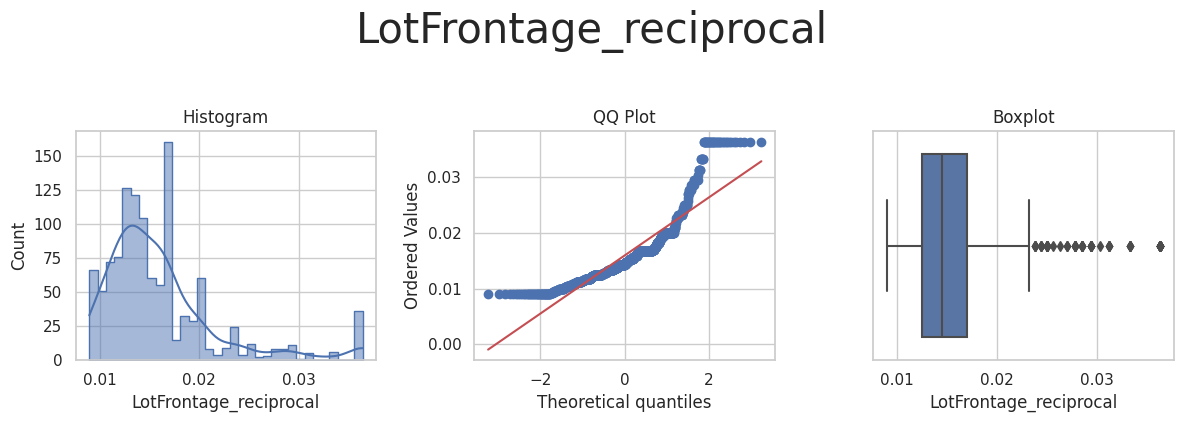

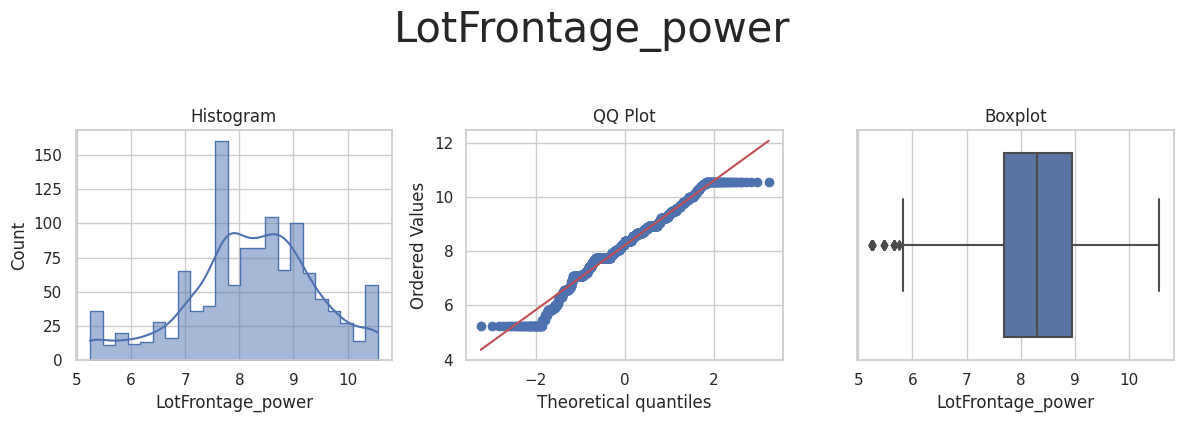

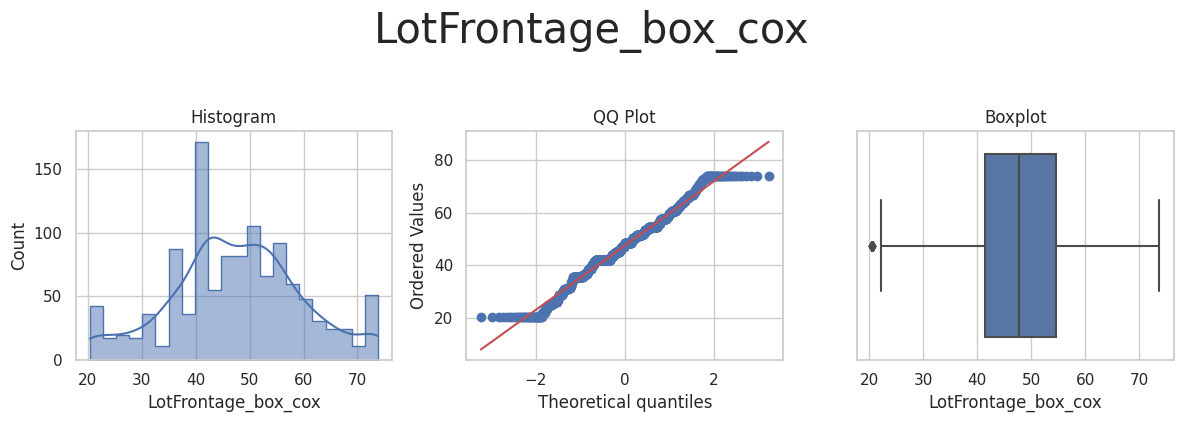

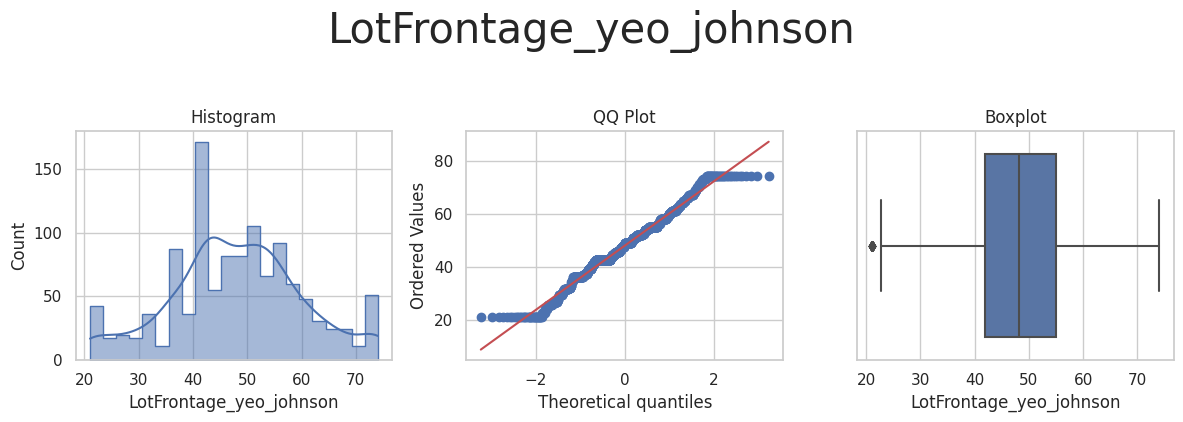



* Variable Analyzed: TotalBsmtSF
* Applied transformation: ['TotalBsmtSF_log_e', 'TotalBsmtSF_log_10', 'TotalBsmtSF_reciprocal', 'TotalBsmtSF_power', 'TotalBsmtSF_box_cox', 'TotalBsmtSF_yeo_johnson'] 



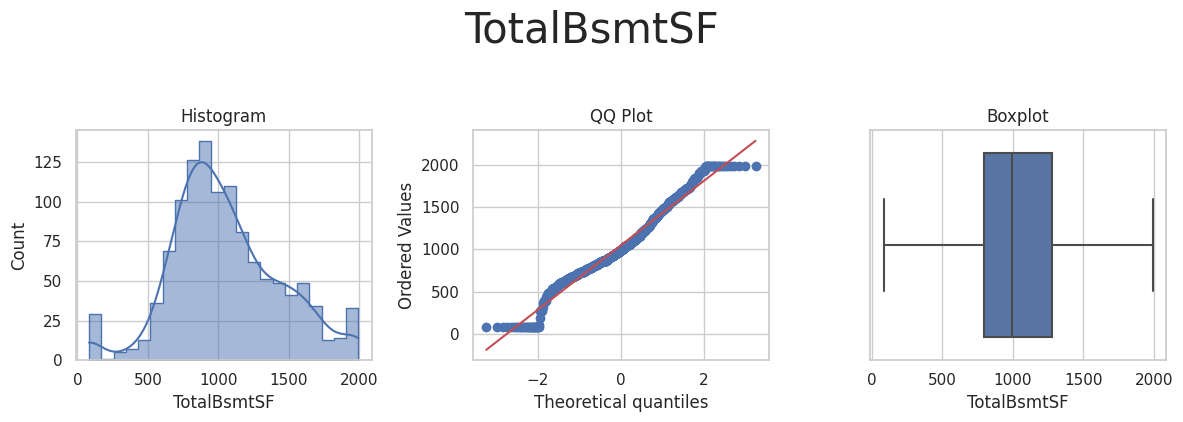

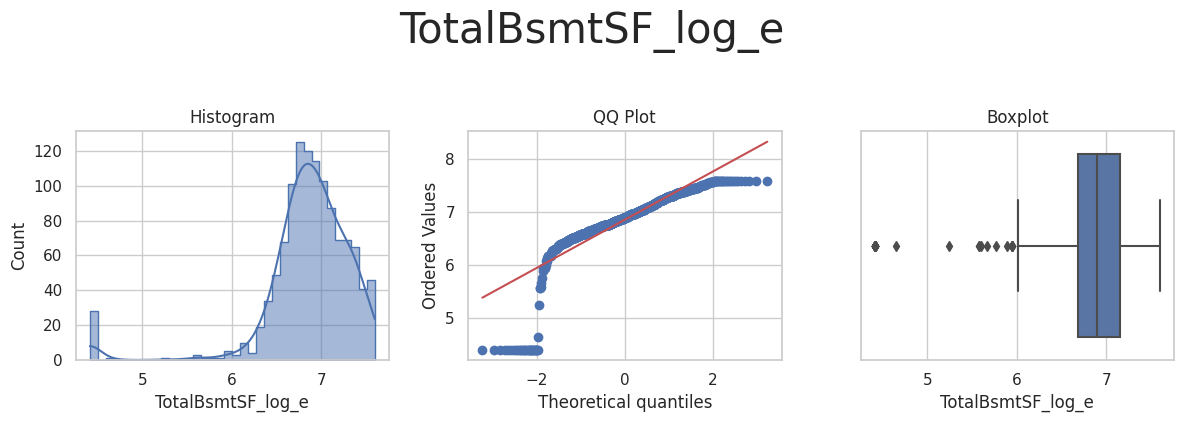

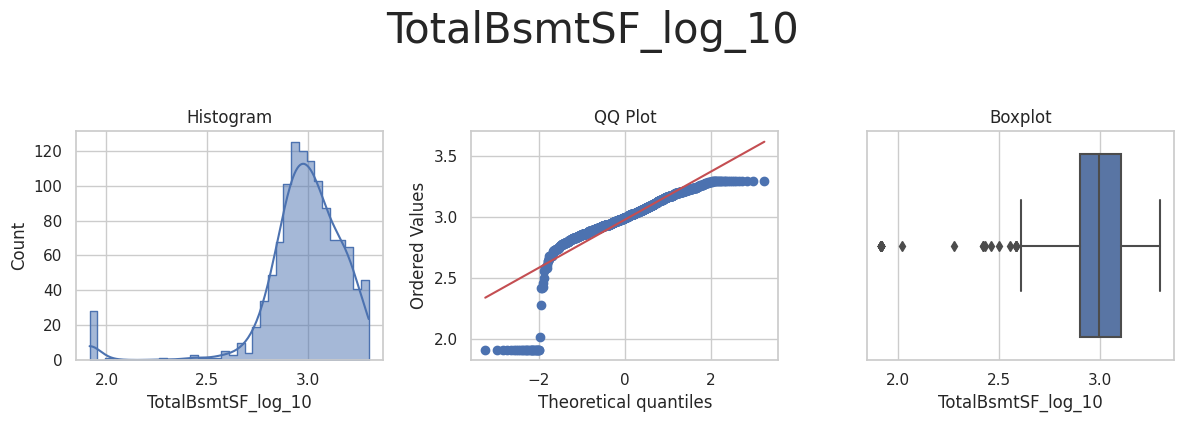

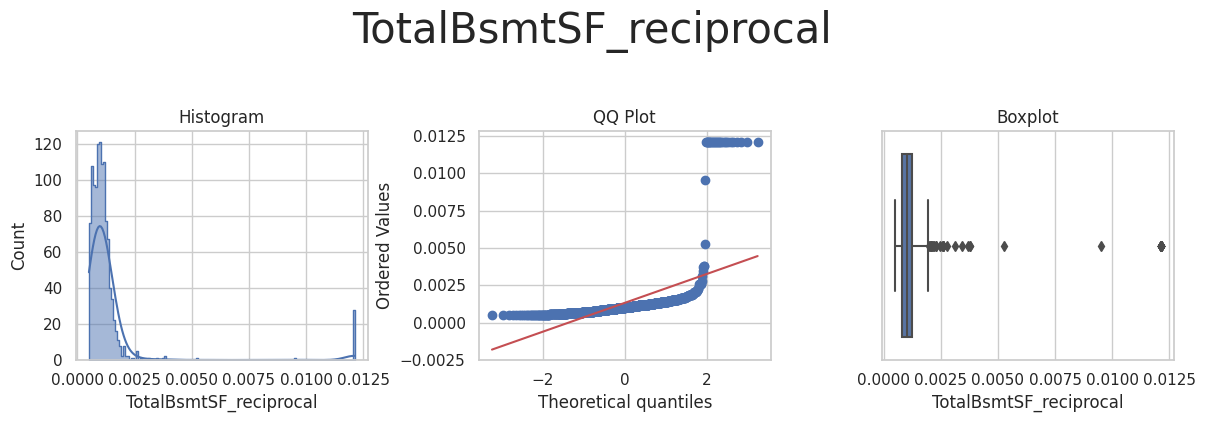

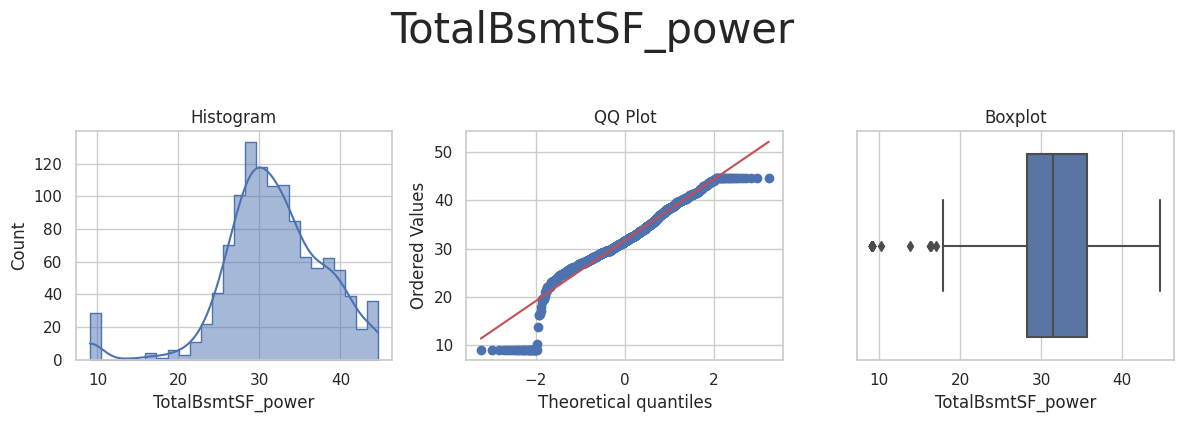

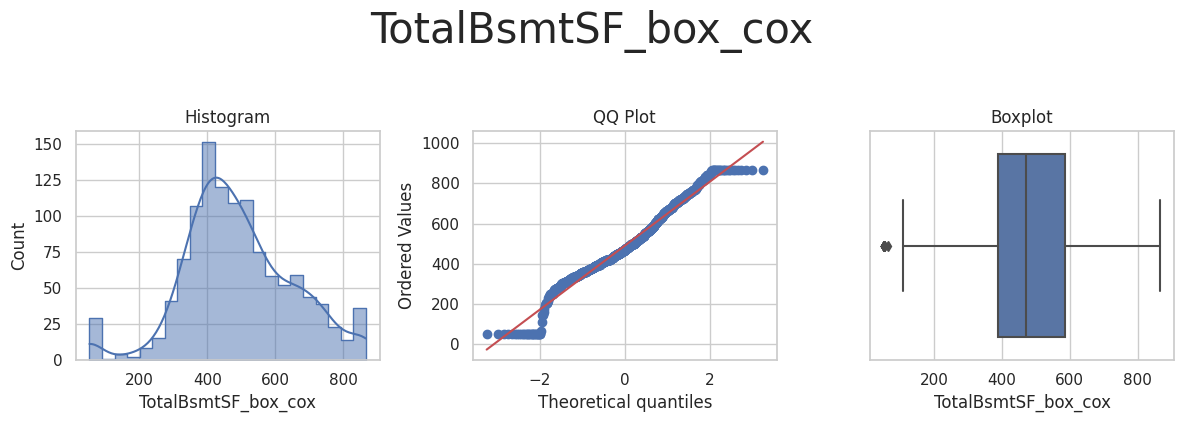

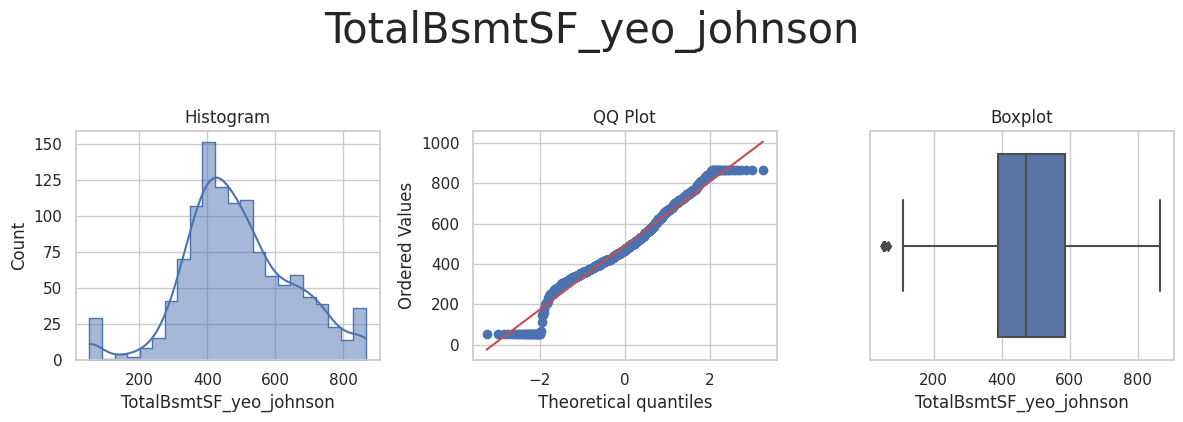



* Variable Analyzed: YearBuilt
* Applied transformation: ['YearBuilt_log_e', 'YearBuilt_log_10', 'YearBuilt_reciprocal', 'YearBuilt_power', 'YearBuilt_box_cox', 'YearBuilt_yeo_johnson'] 



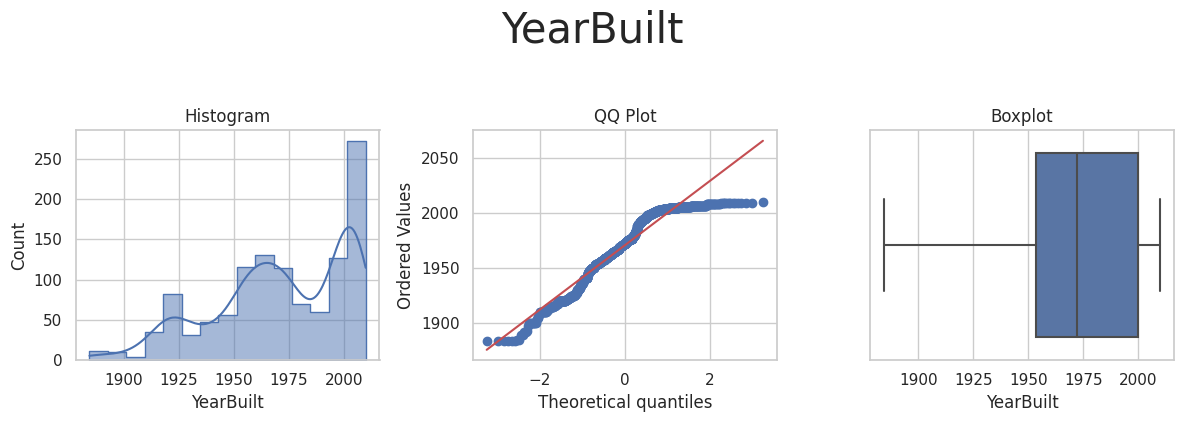

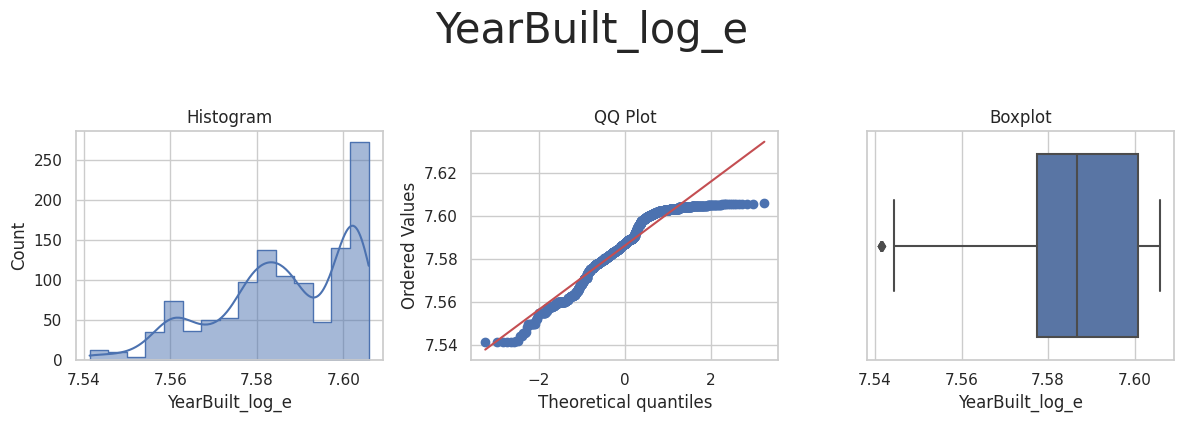

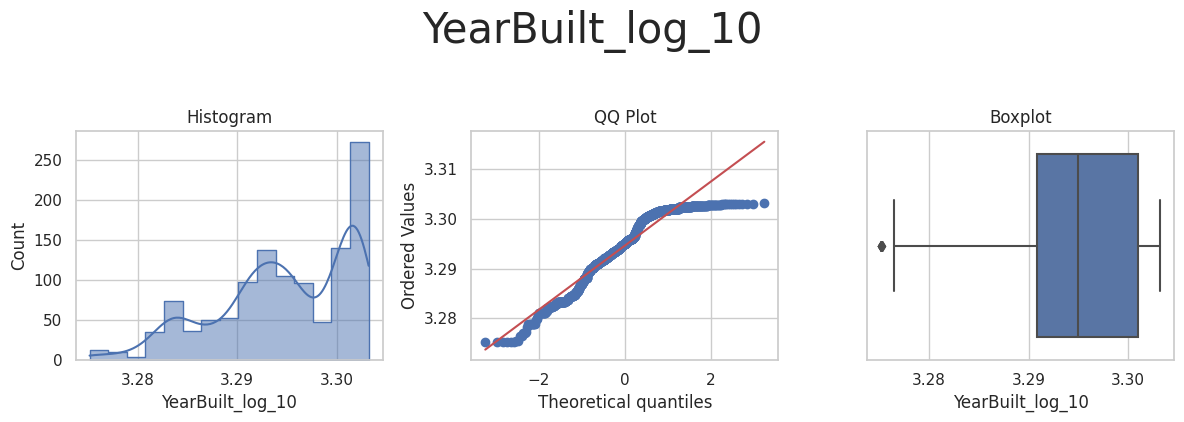

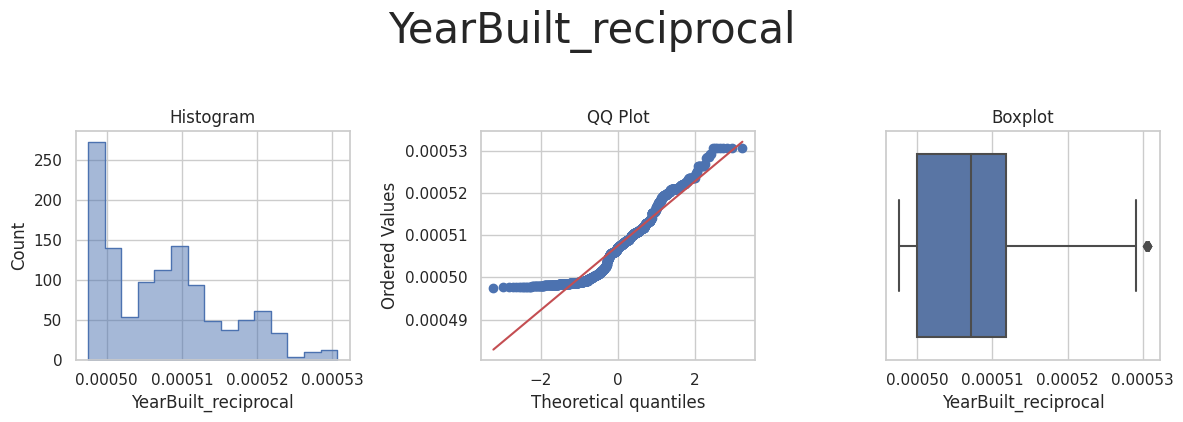

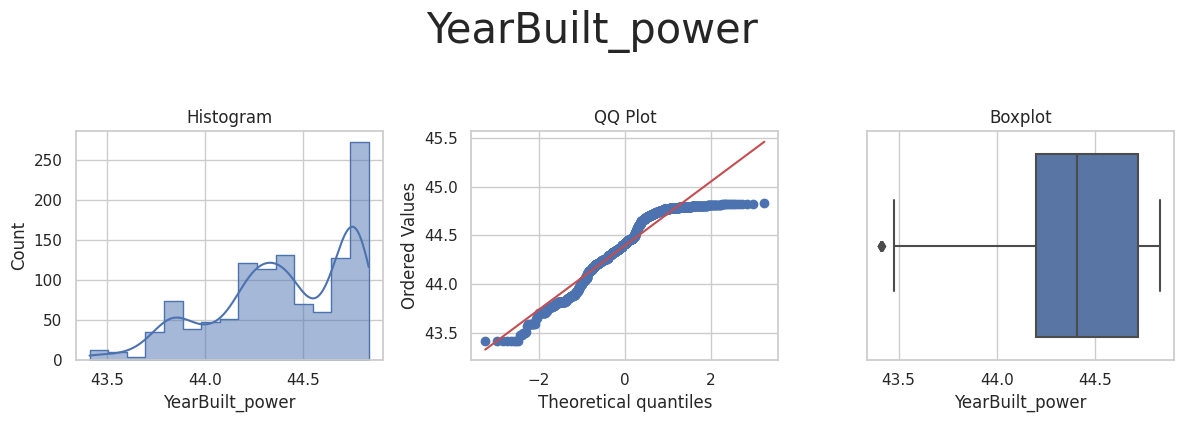

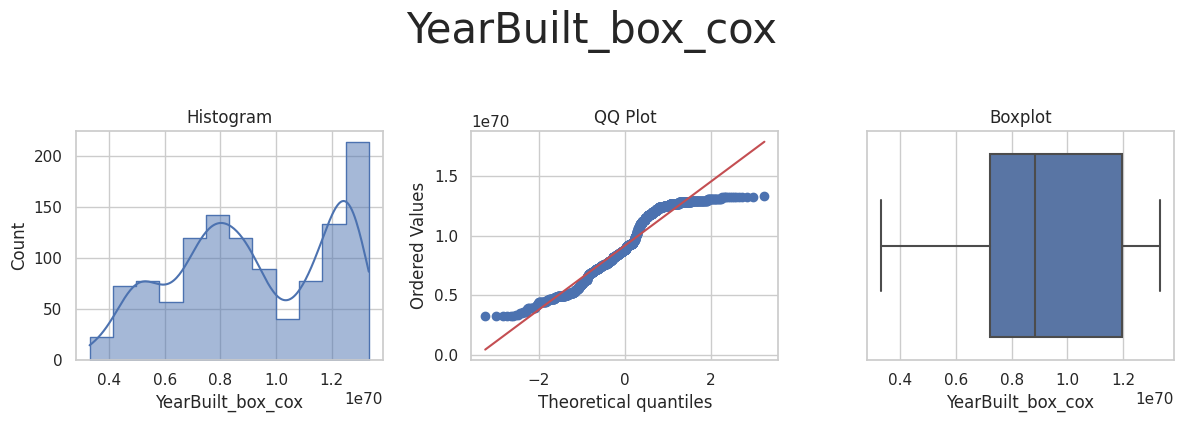

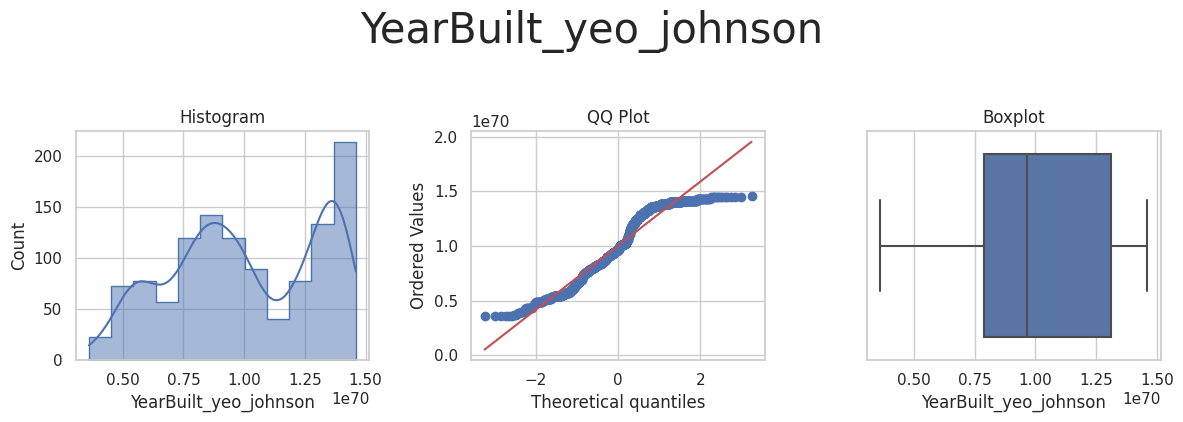

In [51]:
# Numerical transformation
variables_engineering = ['1stFlrSF', 'BedroomAbvGr', 'GarageYrBlt', 'GrLivArea', 'LotArea', 'LotFrontage', 'TotalBsmtSF', 'YearBuilt']
variables_engineering

# Creating a separate DataFrame, with selected variables
df_engineering = TrainSet[variables_engineering].copy()
df_engineering.head(3)

# Creating engineered variabless by applying the transformations, assessing engineered variables distribution and selecting the most suitable method
df_engineering = FeatureEngineeringAnalysis(df=df_engineering, analysis_type='numerical')

#### Observations

* 

In [55]:
# Applying the power transformation to GrLivArea as it is the only variable where the QQ plot shows a more normal distribution after transformation.

from feature_engine.transformation import PowerTransformer

# Initialize the PowerTransformer for the 'GrLivArea' column
power_transformer = PowerTransformer(variables=['GrLivArea'])

# Fit the transformer on the TrainSet
df_feat_eng_train = TrainSet.copy()
power_transformer.fit(df_feat_eng_train)

# Apply the transformation to the TrainSet
df_feat_eng_train = power_transformer.transform(df_feat_eng_train)

# Apply the same transformation to the TestSet
df_feat_eng_test = TestSet.copy()
df_feat_eng_test = power_transformer.transform(df_feat_eng_test)

# Check transformed data
print(df_feat_eng_train[['GrLivArea']].head())
print(df_feat_eng_test[['GrLivArea']].head())

     GrLivArea
618  42.755117
870  29.899833
92   31.048349
817  41.097445
302  39.255573
     GrLivArea
529  50.149776
491  39.724048
459  34.684290
279  44.966654
655  33.045423


In [56]:
# Writing transformed variable into TrainSet and TestSet
TrainSet['GrLivArea'] = df_feat_eng_train['GrLivArea']
TestSet['GrLivArea'] = df_feat_eng_test['GrLivArea']

In [57]:
TrainSet.head(3)

1stFlrSF  BedroomAbvGr  BsmtExposure  BsmtFinType1  GarageFinish  \
618    1828.0           3.0             0             0             0   
870     894.0           2.0             1             1             1   
92      964.0           2.0             1             2             0   

     GarageYrBlt  GrLivArea  KitchenQual  LotArea  LotFrontage  ...  \
618       2007.0  42.755117            0  11694.0         90.0  ...   
870       1962.0  29.899833            1   6600.0         60.0  ...   
92        1921.0  31.048349            1  13360.0         80.0  ...   

     TotalBsmtSF  YearBuilt  SalePrice  Has2ndFloor  HasMasVnr  HasOpenPorch  \
618       1822.0     2007.0     314813            0          0             0   
870        894.0     1962.0     109500            0          1             1   
92         876.0     1921.0     163500            0          1             1   

     HasGarage  HasFinBsmt  ModsMade  SalePriceBand  
618          0           0         0              7  
870          0           1         0              2  
92           0           0         1              3  

[3 rows x 22 columns]

### Smart Correlation

In [58]:
# Carrying out smart scorrelation on the variables
df_engineering = TrainSet.copy()
df_engineering.head(3)


1stFlrSF  BedroomAbvGr  BsmtExposure  BsmtFinType1  GarageFinish  \
618    1828.0           3.0             0             0             0   
870     894.0           2.0             1             1             1   
92      964.0           2.0             1             2             0   

     GarageYrBlt  GrLivArea  KitchenQual  LotArea  LotFrontage  ...  \
618       2007.0  42.755117            0  11694.0         90.0  ...   
870       1962.0  29.899833            1   6600.0         60.0  ...   
92        1921.0  31.048349            1  13360.0         80.0  ...   

     TotalBsmtSF  YearBuilt  SalePrice  Has2ndFloor  HasMasVnr  HasOpenPorch  \
618       1822.0     2007.0     314813            0          0             0   
870        894.0     1962.0     109500            0          1             1   
92         876.0     1921.0     163500            0          1             1   

     HasGarage  HasFinBsmt  ModsMade  SalePriceBand  
618          0           0         0              7  
870          0           1         0              2  
92           0           0         1              3  

[3 rows x 22 columns]

In [59]:
# Creating engineered variables(s) applying the transformation(s)
from feature_engine.selection import SmartCorrelatedSelection
corr_sel = SmartCorrelatedSelection(variables=None, method="spearman", threshold=0.6, selection_method="variance")

corr_sel.fit_transform(df_engineering)
corr_sel.correlated_feature_sets_
corr_sel.features_to_drop_

['1stFlrSF', 'GarageYrBlt', 'YearBuilt', 'HasFinBsmt', 'SalePriceBand']

In [60]:
# Drop '1stFlrSF', 'GarageYrBlt', 'YearBuilt', 'HasFinBsmt' as identified as highly correlated with other variables
TrainSet.drop(['1stFlrSF', 'GarageYrBlt', 'YearBuilt', 'HasFinBsmt'], axis=1, inplace=True)
TestSet.drop(['1stFlrSF', 'GarageYrBlt', 'YearBuilt', 'HasFinBsmt'], axis=1, inplace=True)

TrainSet.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1168 entries, 618 to 684
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   BedroomAbvGr   1168 non-null   float64
 1   BsmtExposure   1168 non-null   int64  
 2   BsmtFinType1   1168 non-null   int64  
 3   GarageFinish   1168 non-null   int64  
 4   GrLivArea      1168 non-null   float64
 5   KitchenQual    1168 non-null   int64  
 6   LotArea        1168 non-null   float64
 7   LotFrontage    1168 non-null   float64
 8   OverallCond    1168 non-null   int64  
 9   OverallQual    1168 non-null   int64  
 10  TotalBsmtSF    1168 non-null   float64
 11  SalePrice      1168 non-null   int64  
 12  Has2ndFloor    1168 non-null   int64  
 13  HasMasVnr      1168 non-null   int64  
 14  HasOpenPorch   1168 non-null   int64  
 15  HasGarage      1168 non-null   int64  
 16  ModsMade       1168 non-null   int64  
 17  SalePriceBand  1168 non-null   int64  
dtypes: floa

---

# Save as new Clean dataset

In [61]:
# Save as file in collections folder

import os
try:
  os.makedirs(name='outputs/datasets/cleaned')
except Exception as e:
  print(e)

[Errno 17] File exists: 'outputs/datasets/cleaned'


In [62]:
# Saving train and test datasets

## Train Set
TrainSet.to_csv("outputs/datasets/cleaned/TrainSetCleaned.csv", index=False)
## Test Set
TestSet.to_csv("outputs/datasets/cleaned/TestSetCleaned.csv", index=False)


---

# Conclusions and Next Steps

* If you do not need to push files to Repo, you may replace this section with "Conclusions and Next Steps" and state your conclusions and next steps.